### Using Python version 3.6 and Tensorflow version 1.7

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(10)
np.random.seed(5)
import time
import sys

/Users/meenakshiparyani/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. (10pts) Define functions

In [2]:
# One hot encode the labels
def one_hot_encode(y):
    targets = np.array(np.unique(y)).reshape(-1)
    enc = np.eye(len(targets))[y]
    return enc

#Get the accuracy of the results
def get_accuracy(y, y_pred):
    y = tf.nn.softmax(y)
    y_pred = tf.nn.softmax(y_pred)
    labels_equal = tf.equal(y, y_pred)
    accuracy = tf.reduce_mean(tf.cast(labels_equal, 'float'))
    return accuracy

# Get the cost of iteration
def get_cost(y, y_pred):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))
    return cost

def plotCostHistory(cost_history):
     plt.plot(cost_history)
     plt.ylabel('Cost');
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations')
     plt.show()

def extract_parameters(hyper_params, key):
    hyper_param = hyper_params[key]
    pad = hyper_param["pad"]
    f = hyper_param["f"]
    stride = hyper_param["stride"]
    filters = hyper_param["channels"]
    #a_prev = tf.pad(a_prev, [[0, 0], [pad, pad], [pad, pad], [0, 0]], "CONSTANT")
    return pad, f, stride, filters

# Flatten the array
def flatten(A):
    return tf.layers.flatten(A)

# Forward propagation to calculate yHat
def forward_propagate_lenet5(x, hyper_params, keep_prob, lamda):

    # Layer 1 Convolution 
    pad_c1, f_c1, stride_c1, filters_out_c1 =  extract_parameters(hyper_params, "c1")
    a1_c = tf.layers.conv2d(inputs=x, filters=filters_out_c1, kernel_size=[f_c1,f_c1],strides=stride_c1, 
    kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1), kernel_regularizer=tf.contrib.layers.l2_regularizer(lamda), bias_initializer=tf.zeros_initializer(), 
                            padding='same',activation=tf.nn.relu) # Relu Activation
    a1_c = tf.nn.dropout(a1_c, keep_prob, seed=2)
    
    print(a1_c)
    
    # Layer 1 Pooling 
    pad_p1, f_p1, stride_p1, filters_out_p1 =  extract_parameters(hyper_params, "p1")
    print(f_p1)
    a1_p = tf.layers.max_pooling2d(inputs = a1_c,pool_size=[f_p1,f_p1], strides=stride_p1)
    print(a1_p)
    a1_p = tf.nn.dropout(a1_p, keep_prob, seed=2)
 
    # Layer 2 Convolution 
    
    pad_c2, f_c2, stride_c2, filters_out_c2 =  extract_parameters(hyper_params, "c2")
    print(" pad {} f {} stid {} filters {}".format(pad_c2, f_c2, stride_c2, filters_out_c2))
    a2_c = tf.layers.conv2d(inputs = a1_p, filters=filters_out_c2, kernel_size=[f_c2,f_c2],
           kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1), kernel_regularizer=tf.contrib.layers.l2_regularizer(lamda), bias_initializer=tf.zeros_initializer(), 
                    strides=stride_c2, padding='valid' , activation=tf.nn.relu) # Relu Activation
    print(a2_c)
    a2_c = tf.nn.dropout(a2_c, keep_prob, seed=2)
    
    # Layer 2 Pooling 
    pad_p2, f_p2, stride_p2, filters_out_p2 =  extract_parameters(hyper_params, "p2")
    a2_p = tf.layers.average_pooling2d(inputs = a2_c, pool_size=[f_p2,f_p2], strides=stride_p2)
    a2_p = tf.nn.dropout(a2_p, keep_prob, seed=2)
    
    print(a2_p)
    # Flatten the array
    a3 = flatten(a2_p)
    print(a3)
    

    # Fully Connected Layer 4
    fc1_size = hyper_params["4"]["size"]
    a4 = tf.layers.dense(inputs = a3, units=fc1_size, activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    a4 = tf.nn.dropout(a4, keep_prob, seed=2)
    print(a4)
    
    
    # Fully Connected Layer 5
    fc2_size = hyper_params["5"]["size"]
    a5 = tf.layers.dense(inputs = a4, units=fc2_size, activation=tf.nn.sigmoid, kernel_initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    print(a5)
    return a5

### 2. Load data

In [3]:
# Load Training Data
X_train = np.load('exam2_train_x.npy')
y_train = np.load('exam2_train_y.npy')
# indx = 2
# plt.imshow(X_train[indx])
# plt.show()
# print("Digit in the image is " + str(y_train[indx]))

# Normalize the training data
X_train_norm = (X_train/255.0) - 0.5
y_train_encoded = one_hot_encode(y_train)

# Load testing Data
X_test = np.load('exam2_test_x.npy')
y_test = np.load('exam2_test_y.npy')
# indx = 2
# plt.imshow(X_test[indx])
# plt.show()
# print("Digit in the image is " + str(y_test[indx]))

# Normalize the test data
X_test_norm = (X_test/255.0) - 0.5
y_test_encoded = one_hot_encode(y_test)
print(X_test_norm.shape)
print(X_train_norm.shape)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

(180, 64, 64, 3)
(1020, 64, 64, 3)
(1020, 6)
(180, 6)


### 3. (10pts) Initialize parameters (Weights, bias for each layer)

In [4]:
def initialize_hyper_params():
    
    hyper_params = {}
    
    # Convolution Layer 1 Hyper Parameters
    hyper_params_c1 = {}
    hyper_params_c1["stride"] = 1
    hyper_params_c1["pad"] = 1
    hyper_params_c1["f"] = 3
    hyper_params_c1["channels"] = 8
    
    # Pooling Layer 1 Hyper Parameters
    hyper_params_p1 = {}
    hyper_params_p1["stride"] = 2
    hyper_params_p1["pad"] = 0
    hyper_params_p1["f"] = 2
    hyper_params_p1["channels"] = 8
    
    # Convolution Layer 2 Hyper Parameters
    hyper_params_c2 = {}
    hyper_params_c2["stride"] = 1
    hyper_params_c2["pad"] = 0
    hyper_params_c2["f"] = 3
    hyper_params_c2["channels"] = 16
    
    # Pooling Layer 2 Hyper Parameters
    hyper_params_p2 = {}
    hyper_params_p2["stride"] = 2
    hyper_params_p2["pad"] = 0
    hyper_params_p2["f"] = 2
    hyper_params_p2["channels"] = 16
    
    hyper_params_4 = {}
    hyper_params_4["size"] = 108
            
    hyper_params_5 = {}
    hyper_params_5["size"] = 6
    
    hyper_params["c1"] = hyper_params_c1
    hyper_params["p1"] = hyper_params_p1
    
    hyper_params["c2"] = hyper_params_c2
    hyper_params["p2"] = hyper_params_p2
    
    hyper_params["4"] = hyper_params_4
    hyper_params["5"] = hyper_params_5
    
    return hyper_params

In [5]:
# hyper_params = initialize_hyper_params()
# (m, nH, nW, nC) = X_train_norm.shape
# X_train_norm = tf.placeholder(tf.float32, [None, nH, nW, nC])
# print(X_train_norm.shape)
# y_pred = forward_propagate_lenet5(X_train_norm, hyper_params)

In [6]:
# hyper_params = initialize_hyper_params()
# (m, nH, nW, nC) = X_train_norm.shape
# x = tf.placeholder(tf.float32, [None, nH, nW, nC])
# y = tf.placeholder(tf.float32)
# y_pred = tf.placeholder(tf.float32)
# y_pred = forward_propagate_lenet5(x, hyper_params)
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))

# optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

# init = tf.global_variables_initializer()

# with tf.Session() as sess:
#     sess.run(init)
#     for epoch in range(1000):
#         _, c = sess.run([optimizer, cost], feed_dict = {x: X_train_norm, y: y_train_encoded})
#         if epoch % 10 == 0:
#             print ("Epoch:", (epoch), "cost =", "{:.5f}".format(c))
#             #print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)) 
#     actual_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
#     accuracy = tf.reduce_mean(tf.cast(actual_prediction, tf.float32))
#     accuracy_tr = accuracy.eval({x: X_train_norm, y: y_train_encoded})
#     accuracy_te = accuracy.eval({x: X_test_norm, y: y_test_encoded})
#     print ("Accuracy on Train Dataset using keep_prob = " + " :", accuracy_tr)
#     print("Accuracy on Test Dataset using keep_prob = "+ " :", accuracy_te)
# elapsed_time = time.time() - start_time
# print ("Time taken to run: ", float(elapsed_time/60))

### 4. (40pts) Build Convolution Neural Network model

In [7]:
def train_cnn_lenet5(epochs, X_train, y_train, X_test, y_test, learning_rate, keep_prob, lamda):
    tf.reset_default_graph()
    (m, nH, nW, nC) = X_train.shape
    x = tf.placeholder(tf.float32, [None, nH, nW, nC])
    y = tf.placeholder(tf.float32)
    hyper_params = initialize_hyper_params()
    y_pred = forward_propagate_lenet5(x, hyper_params, keep_prob, lamda)
    cost = get_cost(y, y_pred)
    
    # The AdamOptimizer is used to optimize the cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) 
    init = tf.global_variables_initializer()
    correctness = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1)) # Softmax Predictions
    accuracy = tf.reduce_mean(tf.cast(correctness, 'float'))
    cost_history = []
    max_test_acc = 0
    max_iter = 0
    train_acc = 0
    test_acc = 0
    old_cost = sys.maxsize
    new_cost = sys.maxsize
    with tf.Session() as sess:
        sess.run(init)
        start_time = time.time() 
        for epoch in range(epochs+1):
            old_cost = new_cost
            temp, epoch_cost = sess.run([optimizer, cost], feed_dict={x:X_train, y:y_train})
            new_cost = epoch_cost
            cost_history.append(epoch_cost)
            if(abs(old_cost - new_cost) < 0.00000000001):
                print("breaking" + str(old_cost) + str(new_cost))
                break;
            if(epoch % 1 == 0):
                train_acc = accuracy.eval({x:X_train, y:y_train})
                test_acc = accuracy.eval({x:X_test, y:y_test}) 
                if(test_acc > max_test_acc):
                    max_test_acc = test_acc
                    print('Max till now is ' , float(max_test_acc))
                    max_iter = epoch
                print('Accuracy Test: ' + str(test_acc) + ' on iteration ' + str(epoch))
                print('Cost is ' + str(epoch_cost) + ' for iteration: ' + str(epoch))
        plotCostHistory(cost_history)
        train_acc = train_acc * 100.0
        test_acc = test_acc * 100.0
        print('Train Accuracy: ', train_acc)
        print('Test Accuracy: ' ,test_acc)
        print('Max Test Accuracy: ' + str(max_test_acc* 100.0) + ' on iteration ' + str(max_iter))
        print('Learning rate: ' , learning_rate)
        print('Keep probability: ' , keep_prob)
        elapsed_time = time.time() - start_time
        print("Time elapsed : " , float(elapsed_time/60))
        return train_acc, test_acc

### 5. (20pts) Optimization of Convolution Neural Network model

**********Learning rate******0.011********Keep prob***********0.7****lamda 0.1
Instructions for updating:
Use the retry module or similar alternatives.
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1388888955116272
Accuracy Test: 0.1388889 on iteration 0
Cost is 1.7925373 for iteration: 0
Max till now is  0.28333333134651184
Accuracy Test: 0.28333333 on iteration 1
Cost is 1.7926965 for iteration: 1
Max till now is  0.36666667461395264
Accuracy Test: 0.36666667 on iteration 2
Cost is 1.765551 for iteration: 2
Max till now is  0.3777777850627899
Accuracy Te

Accuracy Test: 0.87777776 on iteration 84
Cost is 1.0807922 for iteration: 84
Max till now is  0.8999999761581421
Accuracy Test: 0.9 on iteration 85
Cost is 1.0719985 for iteration: 85
Accuracy Test: 0.87222224 on iteration 86
Cost is 1.0737929 for iteration: 86
Accuracy Test: 0.85555553 on iteration 87
Cost is 1.0717103 for iteration: 87
Accuracy Test: 0.87222224 on iteration 88
Cost is 1.0745755 for iteration: 88
Accuracy Test: 0.87777776 on iteration 89
Cost is 1.077184 for iteration: 89
Accuracy Test: 0.8833333 on iteration 90
Cost is 1.0687265 for iteration: 90
Accuracy Test: 0.8666667 on iteration 91
Cost is 1.0716321 for iteration: 91
Accuracy Test: 0.87777776 on iteration 92
Cost is 1.0728836 for iteration: 92
Accuracy Test: 0.87222224 on iteration 93
Cost is 1.0705955 for iteration: 93
Accuracy Test: 0.8888889 on iteration 94
Cost is 1.0692903 for iteration: 94
Accuracy Test: 0.9 on iteration 95
Cost is 1.0707583 for iteration: 95
Max till now is  0.9055555462837219
Accuracy T

Accuracy Test: 0.8833333 on iteration 187
Cost is 1.0519556 for iteration: 187
Accuracy Test: 0.89444447 on iteration 188
Cost is 1.052813 for iteration: 188
Accuracy Test: 0.87777776 on iteration 189
Cost is 1.0540644 for iteration: 189
Accuracy Test: 0.90555555 on iteration 190
Cost is 1.053916 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0563643 for iteration: 191
Accuracy Test: 0.89444447 on iteration 192
Cost is 1.0529352 for iteration: 192
Accuracy Test: 0.89444447 on iteration 193
Cost is 1.0534 for iteration: 193
Accuracy Test: 0.9166667 on iteration 194
Cost is 1.0534581 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.0539739 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.052553 for iteration: 196
Accuracy Test: 0.90555555 on iteration 197
Cost is 1.0510503 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0520514 for iteration: 198
Accuracy Test: 0.90555555 on iteration 199
Cost i

Accuracy Test: 0.8666667 on iteration 291
Cost is 1.0487578 for iteration: 291
Accuracy Test: 0.9 on iteration 292
Cost is 1.0508606 for iteration: 292
Accuracy Test: 0.89444447 on iteration 293
Cost is 1.0480589 for iteration: 293
Accuracy Test: 0.90555555 on iteration 294
Cost is 1.0486807 for iteration: 294
Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0517538 for iteration: 295
Accuracy Test: 0.89444447 on iteration 296
Cost is 1.0532709 for iteration: 296
Accuracy Test: 0.87777776 on iteration 297
Cost is 1.0497777 for iteration: 297
Accuracy Test: 0.89444447 on iteration 298
Cost is 1.0518767 for iteration: 298
Accuracy Test: 0.87777776 on iteration 299
Cost is 1.0533333 for iteration: 299
Accuracy Test: 0.8888889 on iteration 300
Cost is 1.0488437 for iteration: 300
Accuracy Test: 0.89444447 on iteration 301
Cost is 1.0487487 for iteration: 301
Accuracy Test: 0.87777776 on iteration 302
Cost is 1.0493828 for iteration: 302
Accuracy Test: 0.8833333 on iteration 303
Cost is 

Accuracy Test: 0.9111111 on iteration 396
Cost is 1.0479721 for iteration: 396
Accuracy Test: 0.87777776 on iteration 397
Cost is 1.0474262 for iteration: 397
Accuracy Test: 0.8833333 on iteration 398
Cost is 1.0488901 for iteration: 398
Accuracy Test: 0.9222222 on iteration 399
Cost is 1.048189 for iteration: 399
Accuracy Test: 0.90555555 on iteration 400
Cost is 1.0474368 for iteration: 400
Accuracy Test: 0.9111111 on iteration 401
Cost is 1.0467107 for iteration: 401
Accuracy Test: 0.9222222 on iteration 402
Cost is 1.0484995 for iteration: 402
Accuracy Test: 0.8888889 on iteration 403
Cost is 1.0485241 for iteration: 403
Accuracy Test: 0.89444447 on iteration 404
Cost is 1.0487934 for iteration: 404
Accuracy Test: 0.89444447 on iteration 405
Cost is 1.0489624 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0465447 for iteration: 406
Accuracy Test: 0.90555555 on iteration 407
Cost is 1.0478733 for iteration: 407
Accuracy Test: 0.87777776 on iteration 408
Cost

Accuracy Test: 0.8888889 on iteration 500
Cost is 1.0504063 for iteration: 500


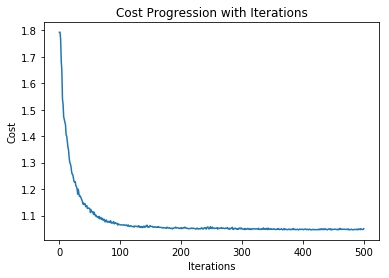

Train Accuracy:  99.70588088035583
Test Accuracy:  88.88888955116272
Max Test Accuracy: 94.44444179534912 on iteration 487
Learning rate:  0.011
Keep probability:  0.7
Time elapsed :  43.85393606821696
**********Learning rate******0.011********Keep prob***********0.7****lamda 10.0
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1388888955116272
Accuracy Test: 0.1388889 on iteration 0
Cost is 1.7925373 for iteration: 0
Max till now is  0.28333333134651184
Accuracy Test: 0.28333333 on iteration 1
Cost is 1.7926965 for iteration: 1
Max till now is  0.3666666746

Accuracy Test: 0.87222224 on iteration 86
Cost is 1.0737929 for iteration: 86
Accuracy Test: 0.85555553 on iteration 87
Cost is 1.0717103 for iteration: 87
Accuracy Test: 0.87222224 on iteration 88
Cost is 1.0745755 for iteration: 88
Accuracy Test: 0.87777776 on iteration 89
Cost is 1.077184 for iteration: 89
Accuracy Test: 0.8833333 on iteration 90
Cost is 1.0687265 for iteration: 90
Accuracy Test: 0.8666667 on iteration 91
Cost is 1.0716321 for iteration: 91
Accuracy Test: 0.87777776 on iteration 92
Cost is 1.0728836 for iteration: 92
Accuracy Test: 0.87222224 on iteration 93
Cost is 1.0705955 for iteration: 93
Accuracy Test: 0.8888889 on iteration 94
Cost is 1.0692903 for iteration: 94
Accuracy Test: 0.9 on iteration 95
Cost is 1.0707583 for iteration: 95
Max till now is  0.9055555462837219
Accuracy Test: 0.90555555 on iteration 96
Cost is 1.0641195 for iteration: 96
Accuracy Test: 0.8611111 on iteration 97
Cost is 1.068079 for iteration: 97
Accuracy Test: 0.8888889 on iteration 98


Accuracy Test: 0.90555555 on iteration 190
Cost is 1.053916 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0563643 for iteration: 191
Accuracy Test: 0.89444447 on iteration 192
Cost is 1.0529352 for iteration: 192
Accuracy Test: 0.89444447 on iteration 193
Cost is 1.0534 for iteration: 193
Accuracy Test: 0.9166667 on iteration 194
Cost is 1.0534581 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.0539739 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.052553 for iteration: 196
Accuracy Test: 0.90555555 on iteration 197
Cost is 1.0510503 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0520514 for iteration: 198
Accuracy Test: 0.90555555 on iteration 199
Cost is 1.0524682 for iteration: 199
Accuracy Test: 0.8833333 on iteration 200
Cost is 1.0544899 for iteration: 200
Accuracy Test: 0.89444447 on iteration 201
Cost is 1.0503775 for iteration: 201
Accuracy Test: 0.87222224 on iteration 202
Cost 

Accuracy Test: 0.90555555 on iteration 294
Cost is 1.0486807 for iteration: 294
Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0517538 for iteration: 295
Accuracy Test: 0.89444447 on iteration 296
Cost is 1.0532709 for iteration: 296
Accuracy Test: 0.87777776 on iteration 297
Cost is 1.0497777 for iteration: 297
Accuracy Test: 0.89444447 on iteration 298
Cost is 1.0518767 for iteration: 298
Accuracy Test: 0.87777776 on iteration 299
Cost is 1.0533333 for iteration: 299
Accuracy Test: 0.8888889 on iteration 300
Cost is 1.0488437 for iteration: 300
Accuracy Test: 0.89444447 on iteration 301
Cost is 1.0487487 for iteration: 301
Accuracy Test: 0.87777776 on iteration 302
Cost is 1.0493828 for iteration: 302
Accuracy Test: 0.8833333 on iteration 303
Cost is 1.04806 for iteration: 303
Accuracy Test: 0.9111111 on iteration 304
Cost is 1.0474659 for iteration: 304
Accuracy Test: 0.8888889 on iteration 305
Cost is 1.051517 for iteration: 305
Accuracy Test: 0.8833333 on iteration 306
Cost i

Accuracy Test: 0.9222222 on iteration 399
Cost is 1.048189 for iteration: 399
Accuracy Test: 0.90555555 on iteration 400
Cost is 1.0474368 for iteration: 400
Accuracy Test: 0.9111111 on iteration 401
Cost is 1.0467107 for iteration: 401
Accuracy Test: 0.9222222 on iteration 402
Cost is 1.0484995 for iteration: 402
Accuracy Test: 0.8888889 on iteration 403
Cost is 1.0485241 for iteration: 403
Accuracy Test: 0.89444447 on iteration 404
Cost is 1.0487934 for iteration: 404
Accuracy Test: 0.89444447 on iteration 405
Cost is 1.0489624 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0465447 for iteration: 406
Accuracy Test: 0.90555555 on iteration 407
Cost is 1.0478733 for iteration: 407
Accuracy Test: 0.87777776 on iteration 408
Cost is 1.048254 for iteration: 408
Accuracy Test: 0.9 on iteration 409
Cost is 1.0467422 for iteration: 409
Accuracy Test: 0.9 on iteration 410
Cost is 1.0473996 for iteration: 410
Accuracy Test: 0.89444447 on iteration 411
Cost is 1.0489596

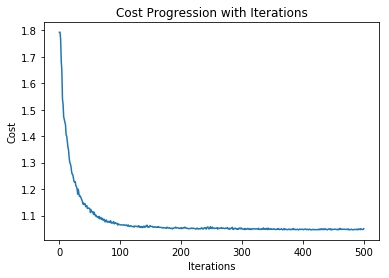

Train Accuracy:  99.70588088035583
Test Accuracy:  88.88888955116272
Max Test Accuracy: 94.44444179534912 on iteration 487
Learning rate:  0.011
Keep probability:  0.7
Time elapsed :  49.28548144499461
**********Learning rate******0.011********Keep prob***********0.7****lamda 0.01
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1388888955116272
Accuracy Test: 0.1388889 on iteration 0
Cost is 1.7925373 for iteration: 0
Max till now is  0.28333333134651184
Accuracy Test: 0.28333333 on iteration 1
Cost is 1.7926965 for iteration: 1
Max till now is  0.3666666746

Accuracy Test: 0.87222224 on iteration 86
Cost is 1.0737929 for iteration: 86
Accuracy Test: 0.85555553 on iteration 87
Cost is 1.0717103 for iteration: 87
Accuracy Test: 0.87222224 on iteration 88
Cost is 1.0745755 for iteration: 88
Accuracy Test: 0.87777776 on iteration 89
Cost is 1.077184 for iteration: 89
Accuracy Test: 0.8833333 on iteration 90
Cost is 1.0687265 for iteration: 90
Accuracy Test: 0.8666667 on iteration 91
Cost is 1.0716321 for iteration: 91
Accuracy Test: 0.87777776 on iteration 92
Cost is 1.0728836 for iteration: 92
Accuracy Test: 0.87222224 on iteration 93
Cost is 1.0705955 for iteration: 93
Accuracy Test: 0.8888889 on iteration 94
Cost is 1.0692903 for iteration: 94
Accuracy Test: 0.9 on iteration 95
Cost is 1.0707583 for iteration: 95
Max till now is  0.9055555462837219
Accuracy Test: 0.90555555 on iteration 96
Cost is 1.0641195 for iteration: 96
Accuracy Test: 0.8611111 on iteration 97
Cost is 1.068079 for iteration: 97
Accuracy Test: 0.8888889 on iteration 98


Accuracy Test: 0.90555555 on iteration 190
Cost is 1.053916 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0563643 for iteration: 191
Accuracy Test: 0.89444447 on iteration 192
Cost is 1.0529352 for iteration: 192
Accuracy Test: 0.89444447 on iteration 193
Cost is 1.0534 for iteration: 193
Accuracy Test: 0.9166667 on iteration 194
Cost is 1.0534581 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.0539739 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.052553 for iteration: 196
Accuracy Test: 0.90555555 on iteration 197
Cost is 1.0510503 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0520514 for iteration: 198
Accuracy Test: 0.90555555 on iteration 199
Cost is 1.0524682 for iteration: 199
Accuracy Test: 0.8833333 on iteration 200
Cost is 1.0544899 for iteration: 200
Accuracy Test: 0.89444447 on iteration 201
Cost is 1.0503775 for iteration: 201
Accuracy Test: 0.87222224 on iteration 202
Cost 

Accuracy Test: 0.90555555 on iteration 294
Cost is 1.0486807 for iteration: 294
Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0517538 for iteration: 295
Accuracy Test: 0.89444447 on iteration 296
Cost is 1.0532709 for iteration: 296
Accuracy Test: 0.87777776 on iteration 297
Cost is 1.0497777 for iteration: 297
Accuracy Test: 0.89444447 on iteration 298
Cost is 1.0518767 for iteration: 298
Accuracy Test: 0.87777776 on iteration 299
Cost is 1.0533333 for iteration: 299
Accuracy Test: 0.8888889 on iteration 300
Cost is 1.0488437 for iteration: 300
Accuracy Test: 0.89444447 on iteration 301
Cost is 1.0487487 for iteration: 301
Accuracy Test: 0.87777776 on iteration 302
Cost is 1.0493828 for iteration: 302
Accuracy Test: 0.8833333 on iteration 303
Cost is 1.04806 for iteration: 303
Accuracy Test: 0.9111111 on iteration 304
Cost is 1.0474659 for iteration: 304
Accuracy Test: 0.8888889 on iteration 305
Cost is 1.051517 for iteration: 305
Accuracy Test: 0.8833333 on iteration 306
Cost i

Accuracy Test: 0.9222222 on iteration 399
Cost is 1.048189 for iteration: 399
Accuracy Test: 0.90555555 on iteration 400
Cost is 1.0474368 for iteration: 400
Accuracy Test: 0.9111111 on iteration 401
Cost is 1.0467107 for iteration: 401
Accuracy Test: 0.9222222 on iteration 402
Cost is 1.0484995 for iteration: 402
Accuracy Test: 0.8888889 on iteration 403
Cost is 1.0485241 for iteration: 403
Accuracy Test: 0.89444447 on iteration 404
Cost is 1.0487934 for iteration: 404
Accuracy Test: 0.89444447 on iteration 405
Cost is 1.0489624 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0465447 for iteration: 406
Accuracy Test: 0.90555555 on iteration 407
Cost is 1.0478733 for iteration: 407
Accuracy Test: 0.87777776 on iteration 408
Cost is 1.048254 for iteration: 408
Accuracy Test: 0.9 on iteration 409
Cost is 1.0467422 for iteration: 409
Accuracy Test: 0.9 on iteration 410
Cost is 1.0473996 for iteration: 410
Accuracy Test: 0.89444447 on iteration 411
Cost is 1.0489596

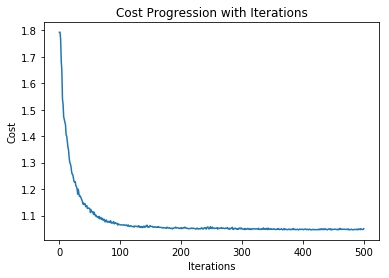

Train Accuracy:  99.70588088035583
Test Accuracy:  88.88888955116272
Max Test Accuracy: 94.44444179534912 on iteration 487
Learning rate:  0.011
Keep probability:  0.7
Time elapsed :  49.46592034896215
**********Learning rate******0.011********Keep prob***********0.7****lamda 0.001
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1388888955116272
Accuracy Test: 0.1388889 on iteration 0
Cost is 1.7925373 for iteration: 0
Max till now is  0.28333333134651184
Accuracy Test: 0.28333333 on iteration 1
Cost is 1.7926965 for iteration: 1
Max till now is  0.366666674

Accuracy Test: 0.87222224 on iteration 86
Cost is 1.0737929 for iteration: 86
Accuracy Test: 0.85555553 on iteration 87
Cost is 1.0717103 for iteration: 87
Accuracy Test: 0.87222224 on iteration 88
Cost is 1.0745755 for iteration: 88
Accuracy Test: 0.87777776 on iteration 89
Cost is 1.077184 for iteration: 89
Accuracy Test: 0.8833333 on iteration 90
Cost is 1.0687265 for iteration: 90
Accuracy Test: 0.8666667 on iteration 91
Cost is 1.0716321 for iteration: 91
Accuracy Test: 0.87777776 on iteration 92
Cost is 1.0728836 for iteration: 92
Accuracy Test: 0.87222224 on iteration 93
Cost is 1.0705955 for iteration: 93
Accuracy Test: 0.8888889 on iteration 94
Cost is 1.0692903 for iteration: 94
Accuracy Test: 0.9 on iteration 95
Cost is 1.0707583 for iteration: 95
Max till now is  0.9055555462837219
Accuracy Test: 0.90555555 on iteration 96
Cost is 1.0641195 for iteration: 96
Accuracy Test: 0.8611111 on iteration 97
Cost is 1.068079 for iteration: 97
Accuracy Test: 0.8888889 on iteration 98


Accuracy Test: 0.90555555 on iteration 190
Cost is 1.053916 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0563643 for iteration: 191
Accuracy Test: 0.89444447 on iteration 192
Cost is 1.0529352 for iteration: 192
Accuracy Test: 0.89444447 on iteration 193
Cost is 1.0534 for iteration: 193
Accuracy Test: 0.9166667 on iteration 194
Cost is 1.0534581 for iteration: 194
Accuracy Test: 0.9111111 on iteration 195
Cost is 1.0539739 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.052553 for iteration: 196
Accuracy Test: 0.90555555 on iteration 197
Cost is 1.0510503 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0520514 for iteration: 198
Accuracy Test: 0.90555555 on iteration 199
Cost is 1.0524682 for iteration: 199
Accuracy Test: 0.8833333 on iteration 200
Cost is 1.0544899 for iteration: 200
Accuracy Test: 0.89444447 on iteration 201
Cost is 1.0503775 for iteration: 201
Accuracy Test: 0.87222224 on iteration 202
Cost 

Accuracy Test: 0.90555555 on iteration 294
Cost is 1.0486807 for iteration: 294
Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0517538 for iteration: 295
Accuracy Test: 0.89444447 on iteration 296
Cost is 1.0532709 for iteration: 296
Accuracy Test: 0.87777776 on iteration 297
Cost is 1.0497777 for iteration: 297
Accuracy Test: 0.89444447 on iteration 298
Cost is 1.0518767 for iteration: 298
Accuracy Test: 0.87777776 on iteration 299
Cost is 1.0533333 for iteration: 299
Accuracy Test: 0.8888889 on iteration 300
Cost is 1.0488437 for iteration: 300
Accuracy Test: 0.89444447 on iteration 301
Cost is 1.0487487 for iteration: 301
Accuracy Test: 0.87777776 on iteration 302
Cost is 1.0493828 for iteration: 302
Accuracy Test: 0.8833333 on iteration 303
Cost is 1.04806 for iteration: 303
Accuracy Test: 0.9111111 on iteration 304
Cost is 1.0474659 for iteration: 304
Accuracy Test: 0.8888889 on iteration 305
Cost is 1.051517 for iteration: 305
Accuracy Test: 0.8833333 on iteration 306
Cost i

Accuracy Test: 0.9222222 on iteration 399
Cost is 1.048189 for iteration: 399
Accuracy Test: 0.90555555 on iteration 400
Cost is 1.0474368 for iteration: 400
Accuracy Test: 0.9111111 on iteration 401
Cost is 1.0467107 for iteration: 401
Accuracy Test: 0.9222222 on iteration 402
Cost is 1.0484995 for iteration: 402
Accuracy Test: 0.8888889 on iteration 403
Cost is 1.0485241 for iteration: 403
Accuracy Test: 0.89444447 on iteration 404
Cost is 1.0487934 for iteration: 404
Accuracy Test: 0.89444447 on iteration 405
Cost is 1.0489624 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0465447 for iteration: 406
Accuracy Test: 0.90555555 on iteration 407
Cost is 1.0478733 for iteration: 407
Accuracy Test: 0.87777776 on iteration 408
Cost is 1.048254 for iteration: 408
Accuracy Test: 0.9 on iteration 409
Cost is 1.0467422 for iteration: 409
Accuracy Test: 0.9 on iteration 410
Cost is 1.0473996 for iteration: 410
Accuracy Test: 0.89444447 on iteration 411
Cost is 1.0489596

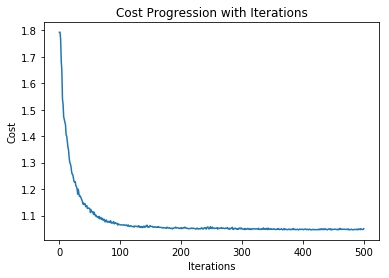

Train Accuracy:  99.70588088035583
Test Accuracy:  88.88888955116272
Max Test Accuracy: 94.44444179534912 on iteration 487
Learning rate:  0.011
Keep probability:  0.7
Time elapsed :  42.214633548259734
**********Learning rate******0.011********Keep prob***********0.8****lamda 0.1
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.15555556118488312
Accuracy Test: 0.15555556 on iteration 0
Cost is 1.7923231 for iteration: 0
Max till now is  0.3166666626930237
Accuracy Test: 0.31666666 on iteration 1
Cost is 1.7903844 for iteration: 1
Max till now is  0.383333325

Accuracy Test: 0.9 on iteration 83
Cost is 1.0677152 for iteration: 83
Accuracy Test: 0.8888889 on iteration 84
Cost is 1.0646616 for iteration: 84
Accuracy Test: 0.89444447 on iteration 85
Cost is 1.0641106 for iteration: 85
Accuracy Test: 0.90555555 on iteration 86
Cost is 1.0646305 for iteration: 86
Accuracy Test: 0.8611111 on iteration 87
Cost is 1.0619248 for iteration: 87
Accuracy Test: 0.8888889 on iteration 88
Cost is 1.0625647 for iteration: 88
Accuracy Test: 0.9111111 on iteration 89
Cost is 1.0630234 for iteration: 89
Accuracy Test: 0.89444447 on iteration 90
Cost is 1.0582794 for iteration: 90
Accuracy Test: 0.8611111 on iteration 91
Cost is 1.0610175 for iteration: 91
Accuracy Test: 0.9111111 on iteration 92
Cost is 1.0587487 for iteration: 92
Accuracy Test: 0.9 on iteration 93
Cost is 1.0579778 for iteration: 93
Accuracy Test: 0.90555555 on iteration 94
Cost is 1.0580974 for iteration: 94
Accuracy Test: 0.8888889 on iteration 95
Cost is 1.0578164 for iteration: 95
Accurac

Accuracy Test: 0.9222222 on iteration 187
Cost is 1.0472801 for iteration: 187
Accuracy Test: 0.9222222 on iteration 188
Cost is 1.0458769 for iteration: 188
Accuracy Test: 0.92777777 on iteration 189
Cost is 1.0459207 for iteration: 189
Accuracy Test: 0.9 on iteration 190
Cost is 1.0480605 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0467576 for iteration: 191
Accuracy Test: 0.9222222 on iteration 192
Cost is 1.0483378 for iteration: 192
Accuracy Test: 0.9166667 on iteration 193
Cost is 1.046429 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.0471352 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0485655 for iteration: 195
Accuracy Test: 0.9222222 on iteration 196
Cost is 1.0484129 for iteration: 196
Accuracy Test: 0.9388889 on iteration 197
Cost is 1.0475292 for iteration: 197
Accuracy Test: 0.93333334 on iteration 198
Cost is 1.0460051 for iteration: 198
Accuracy Test: 0.9166667 on iteration 199
Cost is 1.0457276 fo

Accuracy Test: 0.8888889 on iteration 291
Cost is 1.0456829 for iteration: 291
Max till now is  0.9444444179534912
Accuracy Test: 0.9444444 on iteration 292
Cost is 1.0447228 for iteration: 292
Accuracy Test: 0.89444447 on iteration 293
Cost is 1.0449829 for iteration: 293
Accuracy Test: 0.9166667 on iteration 294
Cost is 1.0453975 for iteration: 294
Accuracy Test: 0.9 on iteration 295
Cost is 1.0461658 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0460902 for iteration: 296
Accuracy Test: 0.8888889 on iteration 297
Cost is 1.0455837 for iteration: 297
Accuracy Test: 0.90555555 on iteration 298
Cost is 1.0461584 for iteration: 298
Accuracy Test: 0.9166667 on iteration 299
Cost is 1.0463077 for iteration: 299
Accuracy Test: 0.9166667 on iteration 300
Cost is 1.0460302 for iteration: 300
Accuracy Test: 0.9166667 on iteration 301
Cost is 1.0452226 for iteration: 301
Accuracy Test: 0.9 on iteration 302
Cost is 1.04616 for iteration: 302
Accuracy Test: 0.9166667 on

Accuracy Test: 0.90555555 on iteration 395
Cost is 1.0457056 for iteration: 395
Accuracy Test: 0.9388889 on iteration 396
Cost is 1.0471399 for iteration: 396
Accuracy Test: 0.9111111 on iteration 397
Cost is 1.0465662 for iteration: 397
Accuracy Test: 0.92777777 on iteration 398
Cost is 1.0461875 for iteration: 398
Accuracy Test: 0.92777777 on iteration 399
Cost is 1.0464301 for iteration: 399
Accuracy Test: 0.9222222 on iteration 400
Cost is 1.0458096 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0459361 for iteration: 401
Accuracy Test: 0.9222222 on iteration 402
Cost is 1.047124 for iteration: 402
Accuracy Test: 0.9166667 on iteration 403
Cost is 1.0465517 for iteration: 403
Accuracy Test: 0.90555555 on iteration 404
Cost is 1.0461748 for iteration: 404
Accuracy Test: 0.9166667 on iteration 405
Cost is 1.0477935 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0454819 for iteration: 406
Accuracy Test: 0.9 on iteration 407
Cost is 1.0

Accuracy Test: 0.93333334 on iteration 500
Cost is 1.0450373 for iteration: 500


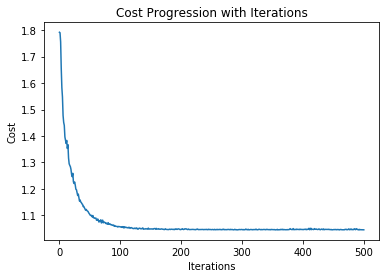

Train Accuracy:  99.90196228027344
Test Accuracy:  93.33333373069763
Max Test Accuracy: 94.44444179534912 on iteration 292
Learning rate:  0.011
Keep probability:  0.8
Time elapsed :  30.505032296975454
**********Learning rate******0.011********Keep prob***********0.8****lamda 10.0
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.15555556118488312
Accuracy Test: 0.15555556 on iteration 0
Cost is 1.7923231 for iteration: 0
Max till now is  0.3166666626930237
Accuracy Test: 0.31666666 on iteration 1
Cost is 1.7903844 for iteration: 1
Max till now is  0.38333332

Accuracy Test: 0.9 on iteration 83
Cost is 1.0677152 for iteration: 83
Accuracy Test: 0.8888889 on iteration 84
Cost is 1.0646616 for iteration: 84
Accuracy Test: 0.89444447 on iteration 85
Cost is 1.0641106 for iteration: 85
Accuracy Test: 0.90555555 on iteration 86
Cost is 1.0646305 for iteration: 86
Accuracy Test: 0.8611111 on iteration 87
Cost is 1.0619248 for iteration: 87
Accuracy Test: 0.8888889 on iteration 88
Cost is 1.0625647 for iteration: 88
Accuracy Test: 0.9111111 on iteration 89
Cost is 1.0630234 for iteration: 89
Accuracy Test: 0.89444447 on iteration 90
Cost is 1.0582794 for iteration: 90
Accuracy Test: 0.8611111 on iteration 91
Cost is 1.0610175 for iteration: 91
Accuracy Test: 0.9111111 on iteration 92
Cost is 1.0587487 for iteration: 92
Accuracy Test: 0.9 on iteration 93
Cost is 1.0579778 for iteration: 93
Accuracy Test: 0.90555555 on iteration 94
Cost is 1.0580974 for iteration: 94
Accuracy Test: 0.8888889 on iteration 95
Cost is 1.0578164 for iteration: 95
Accurac

Accuracy Test: 0.9222222 on iteration 187
Cost is 1.0472801 for iteration: 187
Accuracy Test: 0.9222222 on iteration 188
Cost is 1.0458769 for iteration: 188
Accuracy Test: 0.92777777 on iteration 189
Cost is 1.0459207 for iteration: 189
Accuracy Test: 0.9 on iteration 190
Cost is 1.0480605 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0467576 for iteration: 191
Accuracy Test: 0.9222222 on iteration 192
Cost is 1.0483378 for iteration: 192
Accuracy Test: 0.9166667 on iteration 193
Cost is 1.046429 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.0471352 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0485655 for iteration: 195
Accuracy Test: 0.9222222 on iteration 196
Cost is 1.0484129 for iteration: 196
Accuracy Test: 0.9388889 on iteration 197
Cost is 1.0475292 for iteration: 197
Accuracy Test: 0.93333334 on iteration 198
Cost is 1.0460051 for iteration: 198
Accuracy Test: 0.9166667 on iteration 199
Cost is 1.0457276 fo

Accuracy Test: 0.8888889 on iteration 291
Cost is 1.0456829 for iteration: 291
Max till now is  0.9444444179534912
Accuracy Test: 0.9444444 on iteration 292
Cost is 1.0447228 for iteration: 292
Accuracy Test: 0.89444447 on iteration 293
Cost is 1.0449829 for iteration: 293
Accuracy Test: 0.9166667 on iteration 294
Cost is 1.0453975 for iteration: 294
Accuracy Test: 0.9 on iteration 295
Cost is 1.0461658 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0460902 for iteration: 296
Accuracy Test: 0.8888889 on iteration 297
Cost is 1.0455837 for iteration: 297
Accuracy Test: 0.90555555 on iteration 298
Cost is 1.0461584 for iteration: 298
Accuracy Test: 0.9166667 on iteration 299
Cost is 1.0463077 for iteration: 299
Accuracy Test: 0.9166667 on iteration 300
Cost is 1.0460302 for iteration: 300
Accuracy Test: 0.9166667 on iteration 301
Cost is 1.0452226 for iteration: 301
Accuracy Test: 0.9 on iteration 302
Cost is 1.04616 for iteration: 302
Accuracy Test: 0.9166667 on

Accuracy Test: 0.90555555 on iteration 395
Cost is 1.0457056 for iteration: 395
Accuracy Test: 0.9388889 on iteration 396
Cost is 1.0471399 for iteration: 396
Accuracy Test: 0.9111111 on iteration 397
Cost is 1.0465662 for iteration: 397
Accuracy Test: 0.92777777 on iteration 398
Cost is 1.0461875 for iteration: 398
Accuracy Test: 0.92777777 on iteration 399
Cost is 1.0464301 for iteration: 399
Accuracy Test: 0.9222222 on iteration 400
Cost is 1.0458096 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0459361 for iteration: 401
Accuracy Test: 0.9222222 on iteration 402
Cost is 1.047124 for iteration: 402
Accuracy Test: 0.9166667 on iteration 403
Cost is 1.0465517 for iteration: 403
Accuracy Test: 0.90555555 on iteration 404
Cost is 1.0461748 for iteration: 404
Accuracy Test: 0.9166667 on iteration 405
Cost is 1.0477935 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0454819 for iteration: 406
Accuracy Test: 0.9 on iteration 407
Cost is 1.0

Accuracy Test: 0.93333334 on iteration 500
Cost is 1.0450373 for iteration: 500


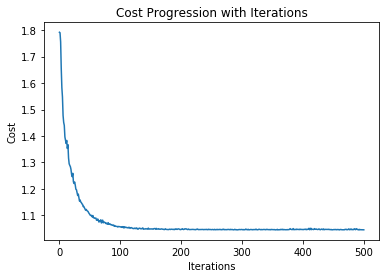

Train Accuracy:  99.90196228027344
Test Accuracy:  93.33333373069763
Max Test Accuracy: 94.44444179534912 on iteration 292
Learning rate:  0.011
Keep probability:  0.8
Time elapsed :  30.457430096467338
**********Learning rate******0.011********Keep prob***********0.8****lamda 0.01
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.15555556118488312
Accuracy Test: 0.15555556 on iteration 0
Cost is 1.7923231 for iteration: 0
Max till now is  0.3166666626930237
Accuracy Test: 0.31666666 on iteration 1
Cost is 1.7903844 for iteration: 1
Max till now is  0.38333332

Accuracy Test: 0.9 on iteration 83
Cost is 1.0677152 for iteration: 83
Accuracy Test: 0.8888889 on iteration 84
Cost is 1.0646616 for iteration: 84
Accuracy Test: 0.89444447 on iteration 85
Cost is 1.0641106 for iteration: 85
Accuracy Test: 0.90555555 on iteration 86
Cost is 1.0646305 for iteration: 86
Accuracy Test: 0.8611111 on iteration 87
Cost is 1.0619248 for iteration: 87
Accuracy Test: 0.8888889 on iteration 88
Cost is 1.0625647 for iteration: 88
Accuracy Test: 0.9111111 on iteration 89
Cost is 1.0630234 for iteration: 89
Accuracy Test: 0.89444447 on iteration 90
Cost is 1.0582794 for iteration: 90
Accuracy Test: 0.8611111 on iteration 91
Cost is 1.0610175 for iteration: 91
Accuracy Test: 0.9111111 on iteration 92
Cost is 1.0587487 for iteration: 92
Accuracy Test: 0.9 on iteration 93
Cost is 1.0579778 for iteration: 93
Accuracy Test: 0.90555555 on iteration 94
Cost is 1.0580974 for iteration: 94
Accuracy Test: 0.8888889 on iteration 95
Cost is 1.0578164 for iteration: 95
Accurac

Accuracy Test: 0.9222222 on iteration 187
Cost is 1.0472801 for iteration: 187
Accuracy Test: 0.9222222 on iteration 188
Cost is 1.0458769 for iteration: 188
Accuracy Test: 0.92777777 on iteration 189
Cost is 1.0459207 for iteration: 189
Accuracy Test: 0.9 on iteration 190
Cost is 1.0480605 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0467576 for iteration: 191
Accuracy Test: 0.9222222 on iteration 192
Cost is 1.0483378 for iteration: 192
Accuracy Test: 0.9166667 on iteration 193
Cost is 1.046429 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.0471352 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0485655 for iteration: 195
Accuracy Test: 0.9222222 on iteration 196
Cost is 1.0484129 for iteration: 196
Accuracy Test: 0.9388889 on iteration 197
Cost is 1.0475292 for iteration: 197
Accuracy Test: 0.93333334 on iteration 198
Cost is 1.0460051 for iteration: 198
Accuracy Test: 0.9166667 on iteration 199
Cost is 1.0457276 fo

Accuracy Test: 0.8888889 on iteration 291
Cost is 1.0456829 for iteration: 291
Max till now is  0.9444444179534912
Accuracy Test: 0.9444444 on iteration 292
Cost is 1.0447228 for iteration: 292
Accuracy Test: 0.89444447 on iteration 293
Cost is 1.0449829 for iteration: 293
Accuracy Test: 0.9166667 on iteration 294
Cost is 1.0453975 for iteration: 294
Accuracy Test: 0.9 on iteration 295
Cost is 1.0461658 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0460902 for iteration: 296
Accuracy Test: 0.8888889 on iteration 297
Cost is 1.0455837 for iteration: 297
Accuracy Test: 0.90555555 on iteration 298
Cost is 1.0461584 for iteration: 298
Accuracy Test: 0.9166667 on iteration 299
Cost is 1.0463077 for iteration: 299
Accuracy Test: 0.9166667 on iteration 300
Cost is 1.0460302 for iteration: 300
Accuracy Test: 0.9166667 on iteration 301
Cost is 1.0452226 for iteration: 301
Accuracy Test: 0.9 on iteration 302
Cost is 1.04616 for iteration: 302
Accuracy Test: 0.9166667 on

Accuracy Test: 0.90555555 on iteration 395
Cost is 1.0457056 for iteration: 395
Accuracy Test: 0.9388889 on iteration 396
Cost is 1.0471399 for iteration: 396
Accuracy Test: 0.9111111 on iteration 397
Cost is 1.0465662 for iteration: 397
Accuracy Test: 0.92777777 on iteration 398
Cost is 1.0461875 for iteration: 398
Accuracy Test: 0.92777777 on iteration 399
Cost is 1.0464301 for iteration: 399
Accuracy Test: 0.9222222 on iteration 400
Cost is 1.0458096 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0459361 for iteration: 401
Accuracy Test: 0.9222222 on iteration 402
Cost is 1.047124 for iteration: 402
Accuracy Test: 0.9166667 on iteration 403
Cost is 1.0465517 for iteration: 403
Accuracy Test: 0.90555555 on iteration 404
Cost is 1.0461748 for iteration: 404
Accuracy Test: 0.9166667 on iteration 405
Cost is 1.0477935 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0454819 for iteration: 406
Accuracy Test: 0.9 on iteration 407
Cost is 1.0

Accuracy Test: 0.93333334 on iteration 500
Cost is 1.0450373 for iteration: 500


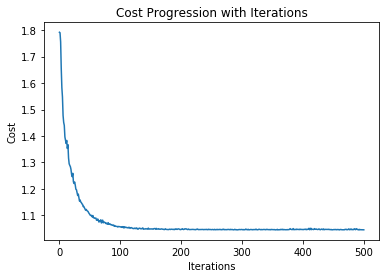

Train Accuracy:  99.90196228027344
Test Accuracy:  93.33333373069763
Max Test Accuracy: 94.44444179534912 on iteration 292
Learning rate:  0.011
Keep probability:  0.8
Time elapsed :  30.53088235060374
**********Learning rate******0.011********Keep prob***********0.8****lamda 0.001
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.15555556118488312
Accuracy Test: 0.15555556 on iteration 0
Cost is 1.7923231 for iteration: 0
Max till now is  0.3166666626930237
Accuracy Test: 0.31666666 on iteration 1
Cost is 1.7903844 for iteration: 1
Max till now is  0.38333332

Accuracy Test: 0.9 on iteration 83
Cost is 1.0677152 for iteration: 83
Accuracy Test: 0.8888889 on iteration 84
Cost is 1.0646616 for iteration: 84
Accuracy Test: 0.89444447 on iteration 85
Cost is 1.0641106 for iteration: 85
Accuracy Test: 0.90555555 on iteration 86
Cost is 1.0646305 for iteration: 86
Accuracy Test: 0.8611111 on iteration 87
Cost is 1.0619248 for iteration: 87
Accuracy Test: 0.8888889 on iteration 88
Cost is 1.0625647 for iteration: 88
Accuracy Test: 0.9111111 on iteration 89
Cost is 1.0630234 for iteration: 89
Accuracy Test: 0.89444447 on iteration 90
Cost is 1.0582794 for iteration: 90
Accuracy Test: 0.8611111 on iteration 91
Cost is 1.0610175 for iteration: 91
Accuracy Test: 0.9111111 on iteration 92
Cost is 1.0587487 for iteration: 92
Accuracy Test: 0.9 on iteration 93
Cost is 1.0579778 for iteration: 93
Accuracy Test: 0.90555555 on iteration 94
Cost is 1.0580974 for iteration: 94
Accuracy Test: 0.8888889 on iteration 95
Cost is 1.0578164 for iteration: 95
Accurac

Accuracy Test: 0.9222222 on iteration 187
Cost is 1.0472801 for iteration: 187
Accuracy Test: 0.9222222 on iteration 188
Cost is 1.0458769 for iteration: 188
Accuracy Test: 0.92777777 on iteration 189
Cost is 1.0459207 for iteration: 189
Accuracy Test: 0.9 on iteration 190
Cost is 1.0480605 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0467576 for iteration: 191
Accuracy Test: 0.9222222 on iteration 192
Cost is 1.0483378 for iteration: 192
Accuracy Test: 0.9166667 on iteration 193
Cost is 1.046429 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.0471352 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0485655 for iteration: 195
Accuracy Test: 0.9222222 on iteration 196
Cost is 1.0484129 for iteration: 196
Accuracy Test: 0.9388889 on iteration 197
Cost is 1.0475292 for iteration: 197
Accuracy Test: 0.93333334 on iteration 198
Cost is 1.0460051 for iteration: 198
Accuracy Test: 0.9166667 on iteration 199
Cost is 1.0457276 fo

Accuracy Test: 0.8888889 on iteration 291
Cost is 1.0456829 for iteration: 291
Max till now is  0.9444444179534912
Accuracy Test: 0.9444444 on iteration 292
Cost is 1.0447228 for iteration: 292
Accuracy Test: 0.89444447 on iteration 293
Cost is 1.0449829 for iteration: 293
Accuracy Test: 0.9166667 on iteration 294
Cost is 1.0453975 for iteration: 294
Accuracy Test: 0.9 on iteration 295
Cost is 1.0461658 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0460902 for iteration: 296
Accuracy Test: 0.8888889 on iteration 297
Cost is 1.0455837 for iteration: 297
Accuracy Test: 0.90555555 on iteration 298
Cost is 1.0461584 for iteration: 298
Accuracy Test: 0.9166667 on iteration 299
Cost is 1.0463077 for iteration: 299
Accuracy Test: 0.9166667 on iteration 300
Cost is 1.0460302 for iteration: 300
Accuracy Test: 0.9166667 on iteration 301
Cost is 1.0452226 for iteration: 301
Accuracy Test: 0.9 on iteration 302
Cost is 1.04616 for iteration: 302
Accuracy Test: 0.9166667 on

Accuracy Test: 0.90555555 on iteration 395
Cost is 1.0457056 for iteration: 395
Accuracy Test: 0.9388889 on iteration 396
Cost is 1.0471399 for iteration: 396
Accuracy Test: 0.9111111 on iteration 397
Cost is 1.0465662 for iteration: 397
Accuracy Test: 0.92777777 on iteration 398
Cost is 1.0461875 for iteration: 398
Accuracy Test: 0.92777777 on iteration 399
Cost is 1.0464301 for iteration: 399
Accuracy Test: 0.9222222 on iteration 400
Cost is 1.0458096 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0459361 for iteration: 401
Accuracy Test: 0.9222222 on iteration 402
Cost is 1.047124 for iteration: 402
Accuracy Test: 0.9166667 on iteration 403
Cost is 1.0465517 for iteration: 403
Accuracy Test: 0.90555555 on iteration 404
Cost is 1.0461748 for iteration: 404
Accuracy Test: 0.9166667 on iteration 405
Cost is 1.0477935 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0454819 for iteration: 406
Accuracy Test: 0.9 on iteration 407
Cost is 1.0

Accuracy Test: 0.93333334 on iteration 500
Cost is 1.0450373 for iteration: 500


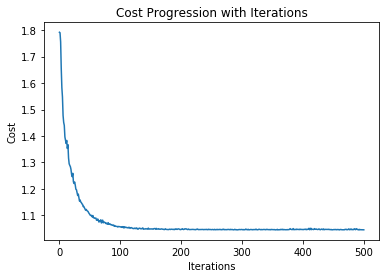

Train Accuracy:  99.90196228027344
Test Accuracy:  93.33333373069763
Max Test Accuracy: 94.44444179534912 on iteration 292
Learning rate:  0.011
Keep probability:  0.8
Time elapsed :  30.51966586907705
**********Learning rate******0.011********Keep prob***********0.9****lamda 0.1
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.18333333730697632
Accuracy Test: 0.18333334 on iteration 0
Cost is 1.7922198 for iteration: 0
Max till now is  0.21111111342906952
Accuracy Test: 0.21111111 on iteration 1
Cost is 1.808643 for iteration: 1
Max till now is  0.3611111044

Accuracy Test: 0.8888889 on iteration 86
Cost is 1.0583435 for iteration: 86
Accuracy Test: 0.89444447 on iteration 87
Cost is 1.057613 for iteration: 87
Accuracy Test: 0.87777776 on iteration 88
Cost is 1.0567664 for iteration: 88
Accuracy Test: 0.87777776 on iteration 89
Cost is 1.0572864 for iteration: 89
Accuracy Test: 0.9 on iteration 90
Cost is 1.0576634 for iteration: 90
Accuracy Test: 0.8833333 on iteration 91
Cost is 1.0569936 for iteration: 91
Accuracy Test: 0.8888889 on iteration 92
Cost is 1.0562603 for iteration: 92
Accuracy Test: 0.89444447 on iteration 93
Cost is 1.0565348 for iteration: 93
Accuracy Test: 0.9 on iteration 94
Cost is 1.0554925 for iteration: 94
Accuracy Test: 0.8833333 on iteration 95
Cost is 1.0561508 for iteration: 95
Accuracy Test: 0.89444447 on iteration 96
Cost is 1.0571804 for iteration: 96
Accuracy Test: 0.89444447 on iteration 97
Cost is 1.0563717 for iteration: 97
Accuracy Test: 0.90555555 on iteration 98
Cost is 1.0572995 for iteration: 98
Accur

Accuracy Test: 0.9111111 on iteration 190
Cost is 1.0525322 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0528923 for iteration: 191
Accuracy Test: 0.9 on iteration 192
Cost is 1.051512 for iteration: 192
Accuracy Test: 0.93333334 on iteration 193
Cost is 1.0534565 for iteration: 193
Accuracy Test: 0.9111111 on iteration 194
Cost is 1.0515386 for iteration: 194
Accuracy Test: 0.89444447 on iteration 195
Cost is 1.0507846 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0506428 for iteration: 196
Accuracy Test: 0.90555555 on iteration 197
Cost is 1.0506082 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0504693 for iteration: 198
Accuracy Test: 0.9111111 on iteration 199
Cost is 1.0504061 for iteration: 199
Accuracy Test: 0.92777777 on iteration 200
Cost is 1.0500717 for iteration: 200
Accuracy Test: 0.9111111 on iteration 201
Cost is 1.0497441 for iteration: 201
Accuracy Test: 0.9111111 on iteration 202
Cost is 1.0

Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0468068 for iteration: 295
Accuracy Test: 0.9 on iteration 296
Cost is 1.0462444 for iteration: 296
Accuracy Test: 0.9111111 on iteration 297
Cost is 1.0473007 for iteration: 297
Accuracy Test: 0.9 on iteration 298
Cost is 1.0469276 for iteration: 298
Accuracy Test: 0.9166667 on iteration 299
Cost is 1.0465363 for iteration: 299
Accuracy Test: 0.89444447 on iteration 300
Cost is 1.0461744 for iteration: 300
Accuracy Test: 0.9 on iteration 301
Cost is 1.047359 for iteration: 301
Accuracy Test: 0.89444447 on iteration 302
Cost is 1.0477622 for iteration: 302
Accuracy Test: 0.90555555 on iteration 303
Cost is 1.0465387 for iteration: 303
Accuracy Test: 0.92777777 on iteration 304
Cost is 1.0470583 for iteration: 304
Accuracy Test: 0.9111111 on iteration 305
Cost is 1.0467486 for iteration: 305
Accuracy Test: 0.9222222 on iteration 306
Cost is 1.0461252 for iteration: 306
Accuracy Test: 0.9222222 on iteration 307
Cost is 1.0464199 for ite

Accuracy Test: 0.8833333 on iteration 400
Cost is 1.0461788 for iteration: 400
Accuracy Test: 0.9111111 on iteration 401
Cost is 1.0462686 for iteration: 401
Accuracy Test: 0.9 on iteration 402
Cost is 1.0464636 for iteration: 402
Accuracy Test: 0.90555555 on iteration 403
Cost is 1.0460969 for iteration: 403
Accuracy Test: 0.9 on iteration 404
Cost is 1.0460457 for iteration: 404
Accuracy Test: 0.9 on iteration 405
Cost is 1.0460912 for iteration: 405
Accuracy Test: 0.9111111 on iteration 406
Cost is 1.0463547 for iteration: 406
Accuracy Test: 0.9111111 on iteration 407
Cost is 1.046373 for iteration: 407
Accuracy Test: 0.89444447 on iteration 408
Cost is 1.0461774 for iteration: 408
Accuracy Test: 0.92777777 on iteration 409
Cost is 1.0465516 for iteration: 409
Accuracy Test: 0.9 on iteration 410
Cost is 1.0460248 for iteration: 410
Accuracy Test: 0.9 on iteration 411
Cost is 1.0462551 for iteration: 411
Accuracy Test: 0.9111111 on iteration 412
Cost is 1.0459416 for iteration: 412
A

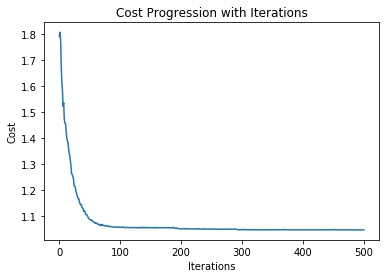

Train Accuracy:  99.70588088035583
Test Accuracy:  90.55555462837219
Max Test Accuracy: 94.44444179534912 on iteration 477
Learning rate:  0.011
Keep probability:  0.9
Time elapsed :  26.157796851793925
**********Learning rate******0.011********Keep prob***********0.9****lamda 10.0
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.18333333730697632
Accuracy Test: 0.18333334 on iteration 0
Cost is 1.7922198 for iteration: 0
Max till now is  0.21111111342906952
Accuracy Test: 0.21111111 on iteration 1
Cost is 1.808643 for iteration: 1
Max till now is  0.36111110

Accuracy Test: 0.8888889 on iteration 86
Cost is 1.0583435 for iteration: 86
Accuracy Test: 0.89444447 on iteration 87
Cost is 1.057613 for iteration: 87
Accuracy Test: 0.87777776 on iteration 88
Cost is 1.0567664 for iteration: 88
Accuracy Test: 0.87777776 on iteration 89
Cost is 1.0572864 for iteration: 89
Accuracy Test: 0.9 on iteration 90
Cost is 1.0576634 for iteration: 90
Accuracy Test: 0.8833333 on iteration 91
Cost is 1.0569936 for iteration: 91
Accuracy Test: 0.8888889 on iteration 92
Cost is 1.0562603 for iteration: 92
Accuracy Test: 0.89444447 on iteration 93
Cost is 1.0565348 for iteration: 93
Accuracy Test: 0.9 on iteration 94
Cost is 1.0554925 for iteration: 94
Accuracy Test: 0.8833333 on iteration 95
Cost is 1.0561508 for iteration: 95
Accuracy Test: 0.89444447 on iteration 96
Cost is 1.0571804 for iteration: 96
Accuracy Test: 0.89444447 on iteration 97
Cost is 1.0563717 for iteration: 97
Accuracy Test: 0.90555555 on iteration 98
Cost is 1.0572995 for iteration: 98
Accur

Accuracy Test: 0.9111111 on iteration 190
Cost is 1.0525322 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0528923 for iteration: 191
Accuracy Test: 0.9 on iteration 192
Cost is 1.051512 for iteration: 192
Accuracy Test: 0.93333334 on iteration 193
Cost is 1.0534565 for iteration: 193
Accuracy Test: 0.9111111 on iteration 194
Cost is 1.0515386 for iteration: 194
Accuracy Test: 0.89444447 on iteration 195
Cost is 1.0507846 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0506428 for iteration: 196
Accuracy Test: 0.90555555 on iteration 197
Cost is 1.0506082 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0504693 for iteration: 198
Accuracy Test: 0.9111111 on iteration 199
Cost is 1.0504061 for iteration: 199
Accuracy Test: 0.92777777 on iteration 200
Cost is 1.0500717 for iteration: 200
Accuracy Test: 0.9111111 on iteration 201
Cost is 1.0497441 for iteration: 201
Accuracy Test: 0.9111111 on iteration 202
Cost is 1.0

Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0468068 for iteration: 295
Accuracy Test: 0.9 on iteration 296
Cost is 1.0462444 for iteration: 296
Accuracy Test: 0.9111111 on iteration 297
Cost is 1.0473007 for iteration: 297
Accuracy Test: 0.9 on iteration 298
Cost is 1.0469276 for iteration: 298
Accuracy Test: 0.9166667 on iteration 299
Cost is 1.0465363 for iteration: 299
Accuracy Test: 0.89444447 on iteration 300
Cost is 1.0461744 for iteration: 300
Accuracy Test: 0.9 on iteration 301
Cost is 1.047359 for iteration: 301
Accuracy Test: 0.89444447 on iteration 302
Cost is 1.0477622 for iteration: 302
Accuracy Test: 0.90555555 on iteration 303
Cost is 1.0465387 for iteration: 303
Accuracy Test: 0.92777777 on iteration 304
Cost is 1.0470583 for iteration: 304
Accuracy Test: 0.9111111 on iteration 305
Cost is 1.0467486 for iteration: 305
Accuracy Test: 0.9222222 on iteration 306
Cost is 1.0461252 for iteration: 306
Accuracy Test: 0.9222222 on iteration 307
Cost is 1.0464199 for ite

Accuracy Test: 0.8833333 on iteration 400
Cost is 1.0461788 for iteration: 400
Accuracy Test: 0.9111111 on iteration 401
Cost is 1.0462686 for iteration: 401
Accuracy Test: 0.9 on iteration 402
Cost is 1.0464636 for iteration: 402
Accuracy Test: 0.90555555 on iteration 403
Cost is 1.0460969 for iteration: 403
Accuracy Test: 0.9 on iteration 404
Cost is 1.0460457 for iteration: 404
Accuracy Test: 0.9 on iteration 405
Cost is 1.0460912 for iteration: 405
Accuracy Test: 0.9111111 on iteration 406
Cost is 1.0463547 for iteration: 406
Accuracy Test: 0.9111111 on iteration 407
Cost is 1.046373 for iteration: 407
Accuracy Test: 0.89444447 on iteration 408
Cost is 1.0461774 for iteration: 408
Accuracy Test: 0.92777777 on iteration 409
Cost is 1.0465516 for iteration: 409
Accuracy Test: 0.9 on iteration 410
Cost is 1.0460248 for iteration: 410
Accuracy Test: 0.9 on iteration 411
Cost is 1.0462551 for iteration: 411
Accuracy Test: 0.9111111 on iteration 412
Cost is 1.0459416 for iteration: 412
A

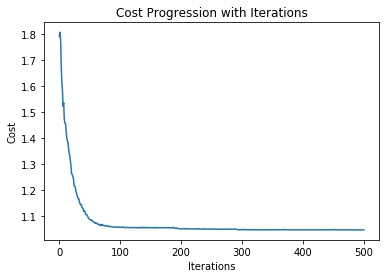

Train Accuracy:  99.70588088035583
Test Accuracy:  90.55555462837219
Max Test Accuracy: 94.44444179534912 on iteration 477
Learning rate:  0.011
Keep probability:  0.9
Time elapsed :  25.809262828032175
**********Learning rate******0.011********Keep prob***********0.9****lamda 0.01
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.18333333730697632
Accuracy Test: 0.18333334 on iteration 0
Cost is 1.7922198 for iteration: 0
Max till now is  0.21111111342906952
Accuracy Test: 0.21111111 on iteration 1
Cost is 1.808643 for iteration: 1
Max till now is  0.36111110

Accuracy Test: 0.8888889 on iteration 86
Cost is 1.0583435 for iteration: 86
Accuracy Test: 0.89444447 on iteration 87
Cost is 1.057613 for iteration: 87
Accuracy Test: 0.87777776 on iteration 88
Cost is 1.0567664 for iteration: 88
Accuracy Test: 0.87777776 on iteration 89
Cost is 1.0572864 for iteration: 89
Accuracy Test: 0.9 on iteration 90
Cost is 1.0576634 for iteration: 90
Accuracy Test: 0.8833333 on iteration 91
Cost is 1.0569936 for iteration: 91
Accuracy Test: 0.8888889 on iteration 92
Cost is 1.0562603 for iteration: 92
Accuracy Test: 0.89444447 on iteration 93
Cost is 1.0565348 for iteration: 93
Accuracy Test: 0.9 on iteration 94
Cost is 1.0554925 for iteration: 94
Accuracy Test: 0.8833333 on iteration 95
Cost is 1.0561508 for iteration: 95
Accuracy Test: 0.89444447 on iteration 96
Cost is 1.0571804 for iteration: 96
Accuracy Test: 0.89444447 on iteration 97
Cost is 1.0563717 for iteration: 97
Accuracy Test: 0.90555555 on iteration 98
Cost is 1.0572995 for iteration: 98
Accur

Accuracy Test: 0.9111111 on iteration 190
Cost is 1.0525322 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0528923 for iteration: 191
Accuracy Test: 0.9 on iteration 192
Cost is 1.051512 for iteration: 192
Accuracy Test: 0.93333334 on iteration 193
Cost is 1.0534565 for iteration: 193
Accuracy Test: 0.9111111 on iteration 194
Cost is 1.0515386 for iteration: 194
Accuracy Test: 0.89444447 on iteration 195
Cost is 1.0507846 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0506428 for iteration: 196
Accuracy Test: 0.90555555 on iteration 197
Cost is 1.0506082 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0504693 for iteration: 198
Accuracy Test: 0.9111111 on iteration 199
Cost is 1.0504061 for iteration: 199
Accuracy Test: 0.92777777 on iteration 200
Cost is 1.0500717 for iteration: 200
Accuracy Test: 0.9111111 on iteration 201
Cost is 1.0497441 for iteration: 201
Accuracy Test: 0.9111111 on iteration 202
Cost is 1.0

Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0468068 for iteration: 295
Accuracy Test: 0.9 on iteration 296
Cost is 1.0462444 for iteration: 296
Accuracy Test: 0.9111111 on iteration 297
Cost is 1.0473007 for iteration: 297
Accuracy Test: 0.9 on iteration 298
Cost is 1.0469276 for iteration: 298
Accuracy Test: 0.9166667 on iteration 299
Cost is 1.0465363 for iteration: 299
Accuracy Test: 0.89444447 on iteration 300
Cost is 1.0461744 for iteration: 300
Accuracy Test: 0.9 on iteration 301
Cost is 1.047359 for iteration: 301
Accuracy Test: 0.89444447 on iteration 302
Cost is 1.0477622 for iteration: 302
Accuracy Test: 0.90555555 on iteration 303
Cost is 1.0465387 for iteration: 303
Accuracy Test: 0.92777777 on iteration 304
Cost is 1.0470583 for iteration: 304
Accuracy Test: 0.9111111 on iteration 305
Cost is 1.0467486 for iteration: 305
Accuracy Test: 0.9222222 on iteration 306
Cost is 1.0461252 for iteration: 306
Accuracy Test: 0.9222222 on iteration 307
Cost is 1.0464199 for ite

Accuracy Test: 0.8833333 on iteration 400
Cost is 1.0461788 for iteration: 400
Accuracy Test: 0.9111111 on iteration 401
Cost is 1.0462686 for iteration: 401
Accuracy Test: 0.9 on iteration 402
Cost is 1.0464636 for iteration: 402
Accuracy Test: 0.90555555 on iteration 403
Cost is 1.0460969 for iteration: 403
Accuracy Test: 0.9 on iteration 404
Cost is 1.0460457 for iteration: 404
Accuracy Test: 0.9 on iteration 405
Cost is 1.0460912 for iteration: 405
Accuracy Test: 0.9111111 on iteration 406
Cost is 1.0463547 for iteration: 406
Accuracy Test: 0.9111111 on iteration 407
Cost is 1.046373 for iteration: 407
Accuracy Test: 0.89444447 on iteration 408
Cost is 1.0461774 for iteration: 408
Accuracy Test: 0.92777777 on iteration 409
Cost is 1.0465516 for iteration: 409
Accuracy Test: 0.9 on iteration 410
Cost is 1.0460248 for iteration: 410
Accuracy Test: 0.9 on iteration 411
Cost is 1.0462551 for iteration: 411
Accuracy Test: 0.9111111 on iteration 412
Cost is 1.0459416 for iteration: 412
A

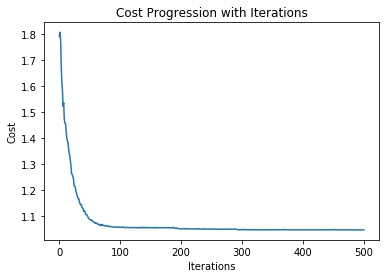

Train Accuracy:  99.70588088035583
Test Accuracy:  90.55555462837219
Max Test Accuracy: 94.44444179534912 on iteration 477
Learning rate:  0.011
Keep probability:  0.9
Time elapsed :  26.092383817831674
**********Learning rate******0.011********Keep prob***********0.9****lamda 0.001
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.18333333730697632
Accuracy Test: 0.18333334 on iteration 0
Cost is 1.7922198 for iteration: 0
Max till now is  0.21111111342906952
Accuracy Test: 0.21111111 on iteration 1
Cost is 1.808643 for iteration: 1
Max till now is  0.3611111

Accuracy Test: 0.8888889 on iteration 86
Cost is 1.0583435 for iteration: 86
Accuracy Test: 0.89444447 on iteration 87
Cost is 1.057613 for iteration: 87
Accuracy Test: 0.87777776 on iteration 88
Cost is 1.0567664 for iteration: 88
Accuracy Test: 0.87777776 on iteration 89
Cost is 1.0572864 for iteration: 89
Accuracy Test: 0.9 on iteration 90
Cost is 1.0576634 for iteration: 90
Accuracy Test: 0.8833333 on iteration 91
Cost is 1.0569936 for iteration: 91
Accuracy Test: 0.8888889 on iteration 92
Cost is 1.0562603 for iteration: 92
Accuracy Test: 0.89444447 on iteration 93
Cost is 1.0565348 for iteration: 93
Accuracy Test: 0.9 on iteration 94
Cost is 1.0554925 for iteration: 94
Accuracy Test: 0.8833333 on iteration 95
Cost is 1.0561508 for iteration: 95
Accuracy Test: 0.89444447 on iteration 96
Cost is 1.0571804 for iteration: 96
Accuracy Test: 0.89444447 on iteration 97
Cost is 1.0563717 for iteration: 97
Accuracy Test: 0.90555555 on iteration 98
Cost is 1.0572995 for iteration: 98
Accur

Accuracy Test: 0.9111111 on iteration 190
Cost is 1.0525322 for iteration: 190
Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0528923 for iteration: 191
Accuracy Test: 0.9 on iteration 192
Cost is 1.051512 for iteration: 192
Accuracy Test: 0.93333334 on iteration 193
Cost is 1.0534565 for iteration: 193
Accuracy Test: 0.9111111 on iteration 194
Cost is 1.0515386 for iteration: 194
Accuracy Test: 0.89444447 on iteration 195
Cost is 1.0507846 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0506428 for iteration: 196
Accuracy Test: 0.90555555 on iteration 197
Cost is 1.0506082 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0504693 for iteration: 198
Accuracy Test: 0.9111111 on iteration 199
Cost is 1.0504061 for iteration: 199
Accuracy Test: 0.92777777 on iteration 200
Cost is 1.0500717 for iteration: 200
Accuracy Test: 0.9111111 on iteration 201
Cost is 1.0497441 for iteration: 201
Accuracy Test: 0.9111111 on iteration 202
Cost is 1.0

Accuracy Test: 0.9111111 on iteration 295
Cost is 1.0468068 for iteration: 295
Accuracy Test: 0.9 on iteration 296
Cost is 1.0462444 for iteration: 296
Accuracy Test: 0.9111111 on iteration 297
Cost is 1.0473007 for iteration: 297
Accuracy Test: 0.9 on iteration 298
Cost is 1.0469276 for iteration: 298
Accuracy Test: 0.9166667 on iteration 299
Cost is 1.0465363 for iteration: 299
Accuracy Test: 0.89444447 on iteration 300
Cost is 1.0461744 for iteration: 300
Accuracy Test: 0.9 on iteration 301
Cost is 1.047359 for iteration: 301
Accuracy Test: 0.89444447 on iteration 302
Cost is 1.0477622 for iteration: 302
Accuracy Test: 0.90555555 on iteration 303
Cost is 1.0465387 for iteration: 303
Accuracy Test: 0.92777777 on iteration 304
Cost is 1.0470583 for iteration: 304
Accuracy Test: 0.9111111 on iteration 305
Cost is 1.0467486 for iteration: 305
Accuracy Test: 0.9222222 on iteration 306
Cost is 1.0461252 for iteration: 306
Accuracy Test: 0.9222222 on iteration 307
Cost is 1.0464199 for ite

Accuracy Test: 0.8833333 on iteration 400
Cost is 1.0461788 for iteration: 400
Accuracy Test: 0.9111111 on iteration 401
Cost is 1.0462686 for iteration: 401
Accuracy Test: 0.9 on iteration 402
Cost is 1.0464636 for iteration: 402
Accuracy Test: 0.90555555 on iteration 403
Cost is 1.0460969 for iteration: 403
Accuracy Test: 0.9 on iteration 404
Cost is 1.0460457 for iteration: 404
Accuracy Test: 0.9 on iteration 405
Cost is 1.0460912 for iteration: 405
Accuracy Test: 0.9111111 on iteration 406
Cost is 1.0463547 for iteration: 406
Accuracy Test: 0.9111111 on iteration 407
Cost is 1.046373 for iteration: 407
Accuracy Test: 0.89444447 on iteration 408
Cost is 1.0461774 for iteration: 408
Accuracy Test: 0.92777777 on iteration 409
Cost is 1.0465516 for iteration: 409
Accuracy Test: 0.9 on iteration 410
Cost is 1.0460248 for iteration: 410
Accuracy Test: 0.9 on iteration 411
Cost is 1.0462551 for iteration: 411
Accuracy Test: 0.9111111 on iteration 412
Cost is 1.0459416 for iteration: 412
A

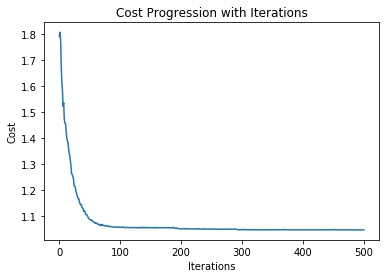

Train Accuracy:  99.70588088035583
Test Accuracy:  90.55555462837219
Max Test Accuracy: 94.44444179534912 on iteration 477
Learning rate:  0.011
Keep probability:  0.9
Time elapsed :  26.223773165543875
**********Learning rate******0.009********Keep prob***********0.7****lamda 0.1
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1388888955116272
Accuracy Test: 0.1388889 on iteration 0
Cost is 1.7925373 for iteration: 0
Max till now is  0.2888889014720917
Accuracy Test: 0.2888889 on iteration 1
Cost is 1.7855964 for iteration: 1
Max till now is  0.383333325386

Accuracy Test: 0.8833333 on iteration 85
Cost is 1.0755221 for iteration: 85
Accuracy Test: 0.87222224 on iteration 86
Cost is 1.0755066 for iteration: 86
Accuracy Test: 0.8833333 on iteration 87
Cost is 1.0733218 for iteration: 87
Accuracy Test: 0.9 on iteration 88
Cost is 1.0712173 for iteration: 88
Accuracy Test: 0.9111111 on iteration 89
Cost is 1.0712444 for iteration: 89
Accuracy Test: 0.89444447 on iteration 90
Cost is 1.0709716 for iteration: 90
Accuracy Test: 0.87777776 on iteration 91
Cost is 1.0708909 for iteration: 91
Accuracy Test: 0.89444447 on iteration 92
Cost is 1.0740309 for iteration: 92
Accuracy Test: 0.8833333 on iteration 93
Cost is 1.0734582 for iteration: 93
Accuracy Test: 0.89444447 on iteration 94
Cost is 1.0671402 for iteration: 94
Accuracy Test: 0.8833333 on iteration 95
Cost is 1.0668015 for iteration: 95
Accuracy Test: 0.8833333 on iteration 96
Cost is 1.0717196 for iteration: 96
Accuracy Test: 0.87777776 on iteration 97
Cost is 1.0726634 for iteration: 97

Accuracy Test: 0.93333334 on iteration 189
Cost is 1.053464 for iteration: 189
Accuracy Test: 0.9111111 on iteration 190
Cost is 1.0492798 for iteration: 190
Accuracy Test: 0.9 on iteration 191
Cost is 1.0533301 for iteration: 191
Accuracy Test: 0.89444447 on iteration 192
Cost is 1.0524265 for iteration: 192
Accuracy Test: 0.90555555 on iteration 193
Cost is 1.0516697 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.0500544 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0515188 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.052607 for iteration: 196
Accuracy Test: 0.9222222 on iteration 197
Cost is 1.0493287 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0527631 for iteration: 198
Accuracy Test: 0.9222222 on iteration 199
Cost is 1.0503093 for iteration: 199
Accuracy Test: 0.90555555 on iteration 200
Cost is 1.0502542 for iteration: 200
Accuracy Test: 0.8833333 on iteration 201
Cost is 1.0528212 

Accuracy Test: 0.90555555 on iteration 293
Cost is 1.049968 for iteration: 293
Accuracy Test: 0.9388889 on iteration 294
Cost is 1.0502833 for iteration: 294
Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0504799 for iteration: 295
Accuracy Test: 0.9111111 on iteration 296
Cost is 1.0481066 for iteration: 296
Accuracy Test: 0.89444447 on iteration 297
Cost is 1.050837 for iteration: 297
Accuracy Test: 0.9388889 on iteration 298
Cost is 1.0484661 for iteration: 298
Accuracy Test: 0.90555555 on iteration 299
Cost is 1.0493122 for iteration: 299
Accuracy Test: 0.9222222 on iteration 300
Cost is 1.0475172 for iteration: 300
Accuracy Test: 0.93333334 on iteration 301
Cost is 1.049269 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0499705 for iteration: 302
Accuracy Test: 0.92777777 on iteration 303
Cost is 1.049353 for iteration: 303
Accuracy Test: 0.93333334 on iteration 304
Cost is 1.049433 for iteration: 304
Accuracy Test: 0.92777777 on iteration 305
Cost is

Accuracy Test: 0.9222222 on iteration 397
Cost is 1.0487335 for iteration: 397
Accuracy Test: 0.9166667 on iteration 398
Cost is 1.0480722 for iteration: 398
Accuracy Test: 0.93333334 on iteration 399
Cost is 1.0485684 for iteration: 399
Accuracy Test: 0.9444444 on iteration 400
Cost is 1.047953 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0469632 for iteration: 401
Accuracy Test: 0.93333334 on iteration 402
Cost is 1.048809 for iteration: 402
Accuracy Test: 0.9388889 on iteration 403
Cost is 1.0519418 for iteration: 403
Accuracy Test: 0.89444447 on iteration 404
Cost is 1.0479075 for iteration: 404
Accuracy Test: 0.9111111 on iteration 405
Cost is 1.0484648 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0484339 for iteration: 406
Accuracy Test: 0.9111111 on iteration 407
Cost is 1.0506335 for iteration: 407
Accuracy Test: 0.90555555 on iteration 408
Cost is 1.050235 for iteration: 408
Accuracy Test: 0.9111111 on iteration 409
Cost is

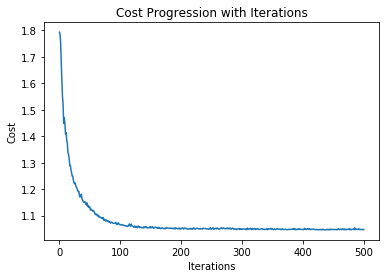

Train Accuracy:  99.60784316062927
Test Accuracy:  89.99999761581421
Max Test Accuracy: 94.9999988079071 on iteration 336
Learning rate:  0.009
Keep probability:  0.7
Time elapsed :  24.418820750713348
**********Learning rate******0.009********Keep prob***********0.7****lamda 10.0
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1388888955116272
Accuracy Test: 0.1388889 on iteration 0
Cost is 1.7925373 for iteration: 0
Max till now is  0.2888889014720917
Accuracy Test: 0.2888889 on iteration 1
Cost is 1.7855964 for iteration: 1
Max till now is  0.383333325386

Accuracy Test: 0.8833333 on iteration 85
Cost is 1.0755221 for iteration: 85
Accuracy Test: 0.87222224 on iteration 86
Cost is 1.0755066 for iteration: 86
Accuracy Test: 0.8833333 on iteration 87
Cost is 1.0733218 for iteration: 87
Accuracy Test: 0.9 on iteration 88
Cost is 1.0712173 for iteration: 88
Accuracy Test: 0.9111111 on iteration 89
Cost is 1.0712444 for iteration: 89
Accuracy Test: 0.89444447 on iteration 90
Cost is 1.0709716 for iteration: 90
Accuracy Test: 0.87777776 on iteration 91
Cost is 1.0708909 for iteration: 91
Accuracy Test: 0.89444447 on iteration 92
Cost is 1.0740309 for iteration: 92
Accuracy Test: 0.8833333 on iteration 93
Cost is 1.0734582 for iteration: 93
Accuracy Test: 0.89444447 on iteration 94
Cost is 1.0671402 for iteration: 94
Accuracy Test: 0.8833333 on iteration 95
Cost is 1.0668015 for iteration: 95
Accuracy Test: 0.8833333 on iteration 96
Cost is 1.0717196 for iteration: 96
Accuracy Test: 0.87777776 on iteration 97
Cost is 1.0726634 for iteration: 97

Accuracy Test: 0.93333334 on iteration 189
Cost is 1.053464 for iteration: 189
Accuracy Test: 0.9111111 on iteration 190
Cost is 1.0492798 for iteration: 190
Accuracy Test: 0.9 on iteration 191
Cost is 1.0533301 for iteration: 191
Accuracy Test: 0.89444447 on iteration 192
Cost is 1.0524265 for iteration: 192
Accuracy Test: 0.90555555 on iteration 193
Cost is 1.0516697 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.0500544 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0515188 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.052607 for iteration: 196
Accuracy Test: 0.9222222 on iteration 197
Cost is 1.0493287 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0527631 for iteration: 198
Accuracy Test: 0.9222222 on iteration 199
Cost is 1.0503093 for iteration: 199
Accuracy Test: 0.90555555 on iteration 200
Cost is 1.0502542 for iteration: 200
Accuracy Test: 0.8833333 on iteration 201
Cost is 1.0528212 

Accuracy Test: 0.90555555 on iteration 293
Cost is 1.049968 for iteration: 293
Accuracy Test: 0.9388889 on iteration 294
Cost is 1.0502833 for iteration: 294
Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0504799 for iteration: 295
Accuracy Test: 0.9111111 on iteration 296
Cost is 1.0481066 for iteration: 296
Accuracy Test: 0.89444447 on iteration 297
Cost is 1.050837 for iteration: 297
Accuracy Test: 0.9388889 on iteration 298
Cost is 1.0484661 for iteration: 298
Accuracy Test: 0.90555555 on iteration 299
Cost is 1.0493122 for iteration: 299
Accuracy Test: 0.9222222 on iteration 300
Cost is 1.0475172 for iteration: 300
Accuracy Test: 0.93333334 on iteration 301
Cost is 1.049269 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0499705 for iteration: 302
Accuracy Test: 0.92777777 on iteration 303
Cost is 1.049353 for iteration: 303
Accuracy Test: 0.93333334 on iteration 304
Cost is 1.049433 for iteration: 304
Accuracy Test: 0.92777777 on iteration 305
Cost is

Accuracy Test: 0.9222222 on iteration 397
Cost is 1.0487335 for iteration: 397
Accuracy Test: 0.9166667 on iteration 398
Cost is 1.0480722 for iteration: 398
Accuracy Test: 0.93333334 on iteration 399
Cost is 1.0485684 for iteration: 399
Accuracy Test: 0.9444444 on iteration 400
Cost is 1.047953 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0469632 for iteration: 401
Accuracy Test: 0.93333334 on iteration 402
Cost is 1.048809 for iteration: 402
Accuracy Test: 0.9388889 on iteration 403
Cost is 1.0519418 for iteration: 403
Accuracy Test: 0.89444447 on iteration 404
Cost is 1.0479075 for iteration: 404
Accuracy Test: 0.9111111 on iteration 405
Cost is 1.0484648 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0484339 for iteration: 406
Accuracy Test: 0.9111111 on iteration 407
Cost is 1.0506335 for iteration: 407
Accuracy Test: 0.90555555 on iteration 408
Cost is 1.050235 for iteration: 408
Accuracy Test: 0.9111111 on iteration 409
Cost is

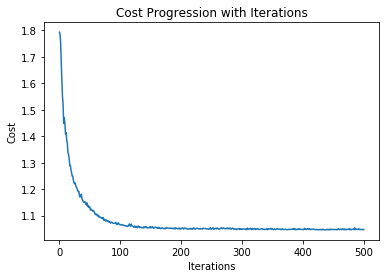

Train Accuracy:  99.60784316062927
Test Accuracy:  89.99999761581421
Max Test Accuracy: 94.9999988079071 on iteration 336
Learning rate:  0.009
Keep probability:  0.7
Time elapsed :  28.743143033981323
**********Learning rate******0.009********Keep prob***********0.7****lamda 0.01
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1388888955116272
Accuracy Test: 0.1388889 on iteration 0
Cost is 1.7925373 for iteration: 0
Max till now is  0.2888889014720917
Accuracy Test: 0.2888889 on iteration 1
Cost is 1.7855964 for iteration: 1
Max till now is  0.383333325386

Accuracy Test: 0.8833333 on iteration 85
Cost is 1.0755221 for iteration: 85
Accuracy Test: 0.87222224 on iteration 86
Cost is 1.0755066 for iteration: 86
Accuracy Test: 0.8833333 on iteration 87
Cost is 1.0733218 for iteration: 87
Accuracy Test: 0.9 on iteration 88
Cost is 1.0712173 for iteration: 88
Accuracy Test: 0.9111111 on iteration 89
Cost is 1.0712444 for iteration: 89
Accuracy Test: 0.89444447 on iteration 90
Cost is 1.0709716 for iteration: 90
Accuracy Test: 0.87777776 on iteration 91
Cost is 1.0708909 for iteration: 91
Accuracy Test: 0.89444447 on iteration 92
Cost is 1.0740309 for iteration: 92
Accuracy Test: 0.8833333 on iteration 93
Cost is 1.0734582 for iteration: 93
Accuracy Test: 0.89444447 on iteration 94
Cost is 1.0671402 for iteration: 94
Accuracy Test: 0.8833333 on iteration 95
Cost is 1.0668015 for iteration: 95
Accuracy Test: 0.8833333 on iteration 96
Cost is 1.0717196 for iteration: 96
Accuracy Test: 0.87777776 on iteration 97
Cost is 1.0726634 for iteration: 97

Accuracy Test: 0.93333334 on iteration 189
Cost is 1.053464 for iteration: 189
Accuracy Test: 0.9111111 on iteration 190
Cost is 1.0492798 for iteration: 190
Accuracy Test: 0.9 on iteration 191
Cost is 1.0533301 for iteration: 191
Accuracy Test: 0.89444447 on iteration 192
Cost is 1.0524265 for iteration: 192
Accuracy Test: 0.90555555 on iteration 193
Cost is 1.0516697 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.0500544 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0515188 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.052607 for iteration: 196
Accuracy Test: 0.9222222 on iteration 197
Cost is 1.0493287 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0527631 for iteration: 198
Accuracy Test: 0.9222222 on iteration 199
Cost is 1.0503093 for iteration: 199
Accuracy Test: 0.90555555 on iteration 200
Cost is 1.0502542 for iteration: 200
Accuracy Test: 0.8833333 on iteration 201
Cost is 1.0528212 

Accuracy Test: 0.90555555 on iteration 293
Cost is 1.049968 for iteration: 293
Accuracy Test: 0.9388889 on iteration 294
Cost is 1.0502833 for iteration: 294
Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0504799 for iteration: 295
Accuracy Test: 0.9111111 on iteration 296
Cost is 1.0481066 for iteration: 296
Accuracy Test: 0.89444447 on iteration 297
Cost is 1.050837 for iteration: 297
Accuracy Test: 0.9388889 on iteration 298
Cost is 1.0484661 for iteration: 298
Accuracy Test: 0.90555555 on iteration 299
Cost is 1.0493122 for iteration: 299
Accuracy Test: 0.9222222 on iteration 300
Cost is 1.0475172 for iteration: 300
Accuracy Test: 0.93333334 on iteration 301
Cost is 1.049269 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0499705 for iteration: 302
Accuracy Test: 0.92777777 on iteration 303
Cost is 1.049353 for iteration: 303
Accuracy Test: 0.93333334 on iteration 304
Cost is 1.049433 for iteration: 304
Accuracy Test: 0.92777777 on iteration 305
Cost is

Accuracy Test: 0.9222222 on iteration 397
Cost is 1.0487335 for iteration: 397
Accuracy Test: 0.9166667 on iteration 398
Cost is 1.0480722 for iteration: 398
Accuracy Test: 0.93333334 on iteration 399
Cost is 1.0485684 for iteration: 399
Accuracy Test: 0.9444444 on iteration 400
Cost is 1.047953 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0469632 for iteration: 401
Accuracy Test: 0.93333334 on iteration 402
Cost is 1.048809 for iteration: 402
Accuracy Test: 0.9388889 on iteration 403
Cost is 1.0519418 for iteration: 403
Accuracy Test: 0.89444447 on iteration 404
Cost is 1.0479075 for iteration: 404
Accuracy Test: 0.9111111 on iteration 405
Cost is 1.0484648 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0484339 for iteration: 406
Accuracy Test: 0.9111111 on iteration 407
Cost is 1.0506335 for iteration: 407
Accuracy Test: 0.90555555 on iteration 408
Cost is 1.050235 for iteration: 408
Accuracy Test: 0.9111111 on iteration 409
Cost is

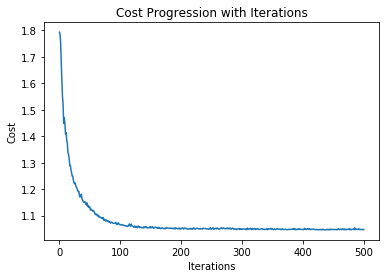

Train Accuracy:  99.60784316062927
Test Accuracy:  89.99999761581421
Max Test Accuracy: 94.9999988079071 on iteration 336
Learning rate:  0.009
Keep probability:  0.7
Time elapsed :  29.853448287645975
**********Learning rate******0.009********Keep prob***********0.7****lamda 0.001
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1388888955116272
Accuracy Test: 0.1388889 on iteration 0
Cost is 1.7925373 for iteration: 0
Max till now is  0.2888889014720917
Accuracy Test: 0.2888889 on iteration 1
Cost is 1.7855964 for iteration: 1
Max till now is  0.38333332538

Accuracy Test: 0.8833333 on iteration 85
Cost is 1.0755221 for iteration: 85
Accuracy Test: 0.87222224 on iteration 86
Cost is 1.0755066 for iteration: 86
Accuracy Test: 0.8833333 on iteration 87
Cost is 1.0733218 for iteration: 87
Accuracy Test: 0.9 on iteration 88
Cost is 1.0712173 for iteration: 88
Accuracy Test: 0.9111111 on iteration 89
Cost is 1.0712444 for iteration: 89
Accuracy Test: 0.89444447 on iteration 90
Cost is 1.0709716 for iteration: 90
Accuracy Test: 0.87777776 on iteration 91
Cost is 1.0708909 for iteration: 91
Accuracy Test: 0.89444447 on iteration 92
Cost is 1.0740309 for iteration: 92
Accuracy Test: 0.8833333 on iteration 93
Cost is 1.0734582 for iteration: 93
Accuracy Test: 0.89444447 on iteration 94
Cost is 1.0671402 for iteration: 94
Accuracy Test: 0.8833333 on iteration 95
Cost is 1.0668015 for iteration: 95
Accuracy Test: 0.8833333 on iteration 96
Cost is 1.0717196 for iteration: 96
Accuracy Test: 0.87777776 on iteration 97
Cost is 1.0726634 for iteration: 97

Accuracy Test: 0.93333334 on iteration 189
Cost is 1.053464 for iteration: 189
Accuracy Test: 0.9111111 on iteration 190
Cost is 1.0492798 for iteration: 190
Accuracy Test: 0.9 on iteration 191
Cost is 1.0533301 for iteration: 191
Accuracy Test: 0.89444447 on iteration 192
Cost is 1.0524265 for iteration: 192
Accuracy Test: 0.90555555 on iteration 193
Cost is 1.0516697 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.0500544 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0515188 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.052607 for iteration: 196
Accuracy Test: 0.9222222 on iteration 197
Cost is 1.0493287 for iteration: 197
Accuracy Test: 0.90555555 on iteration 198
Cost is 1.0527631 for iteration: 198
Accuracy Test: 0.9222222 on iteration 199
Cost is 1.0503093 for iteration: 199
Accuracy Test: 0.90555555 on iteration 200
Cost is 1.0502542 for iteration: 200
Accuracy Test: 0.8833333 on iteration 201
Cost is 1.0528212 

Accuracy Test: 0.90555555 on iteration 293
Cost is 1.049968 for iteration: 293
Accuracy Test: 0.9388889 on iteration 294
Cost is 1.0502833 for iteration: 294
Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0504799 for iteration: 295
Accuracy Test: 0.9111111 on iteration 296
Cost is 1.0481066 for iteration: 296
Accuracy Test: 0.89444447 on iteration 297
Cost is 1.050837 for iteration: 297
Accuracy Test: 0.9388889 on iteration 298
Cost is 1.0484661 for iteration: 298
Accuracy Test: 0.90555555 on iteration 299
Cost is 1.0493122 for iteration: 299
Accuracy Test: 0.9222222 on iteration 300
Cost is 1.0475172 for iteration: 300
Accuracy Test: 0.93333334 on iteration 301
Cost is 1.049269 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0499705 for iteration: 302
Accuracy Test: 0.92777777 on iteration 303
Cost is 1.049353 for iteration: 303
Accuracy Test: 0.93333334 on iteration 304
Cost is 1.049433 for iteration: 304
Accuracy Test: 0.92777777 on iteration 305
Cost is

Accuracy Test: 0.9222222 on iteration 397
Cost is 1.0487335 for iteration: 397
Accuracy Test: 0.9166667 on iteration 398
Cost is 1.0480722 for iteration: 398
Accuracy Test: 0.93333334 on iteration 399
Cost is 1.0485684 for iteration: 399
Accuracy Test: 0.9444444 on iteration 400
Cost is 1.047953 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0469632 for iteration: 401
Accuracy Test: 0.93333334 on iteration 402
Cost is 1.048809 for iteration: 402
Accuracy Test: 0.9388889 on iteration 403
Cost is 1.0519418 for iteration: 403
Accuracy Test: 0.89444447 on iteration 404
Cost is 1.0479075 for iteration: 404
Accuracy Test: 0.9111111 on iteration 405
Cost is 1.0484648 for iteration: 405
Accuracy Test: 0.93333334 on iteration 406
Cost is 1.0484339 for iteration: 406
Accuracy Test: 0.9111111 on iteration 407
Cost is 1.0506335 for iteration: 407
Accuracy Test: 0.90555555 on iteration 408
Cost is 1.050235 for iteration: 408
Accuracy Test: 0.9111111 on iteration 409
Cost is

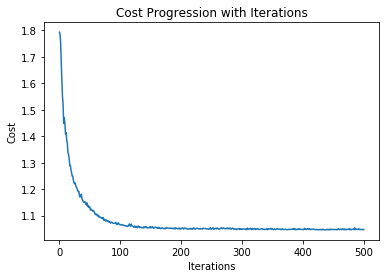

Train Accuracy:  99.60784316062927
Test Accuracy:  89.99999761581421
Max Test Accuracy: 94.9999988079071 on iteration 336
Learning rate:  0.009
Keep probability:  0.7
Time elapsed :  29.902933716773987
**********Learning rate******0.009********Keep prob***********0.8****lamda 0.1
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1666666716337204
Accuracy Test: 0.16666667 on iteration 0
Cost is 1.7923231 for iteration: 0
Max till now is  0.3055555522441864
Accuracy Test: 0.30555555 on iteration 1
Cost is 1.7822574 for iteration: 1
Accuracy Test: 0.30555555 on i

Accuracy Test: 0.8888889 on iteration 87
Cost is 1.0639665 for iteration: 87
Accuracy Test: 0.90555555 on iteration 88
Cost is 1.0625286 for iteration: 88
Max till now is  0.949999988079071
Accuracy Test: 0.95 on iteration 89
Cost is 1.0658705 for iteration: 89
Accuracy Test: 0.9166667 on iteration 90
Cost is 1.0616281 for iteration: 90
Accuracy Test: 0.8888889 on iteration 91
Cost is 1.0617777 for iteration: 91
Accuracy Test: 0.9111111 on iteration 92
Cost is 1.0600702 for iteration: 92
Accuracy Test: 0.89444447 on iteration 93
Cost is 1.0618815 for iteration: 93
Accuracy Test: 0.9111111 on iteration 94
Cost is 1.0605515 for iteration: 94
Accuracy Test: 0.90555555 on iteration 95
Cost is 1.0618777 for iteration: 95
Accuracy Test: 0.8833333 on iteration 96
Cost is 1.0583003 for iteration: 96
Accuracy Test: 0.9 on iteration 97
Cost is 1.058114 for iteration: 97
Accuracy Test: 0.9111111 on iteration 98
Cost is 1.0617405 for iteration: 98
Accuracy Test: 0.93333334 on iteration 99
Cost is 

Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0470374 for iteration: 191
Accuracy Test: 0.90555555 on iteration 192
Cost is 1.0489973 for iteration: 192
Accuracy Test: 0.9166667 on iteration 193
Cost is 1.0473503 for iteration: 193
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.0478635 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0470679 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0474231 for iteration: 196
Accuracy Test: 0.9388889 on iteration 197
Cost is 1.0463539 for iteration: 197
Accuracy Test: 0.9388889 on iteration 198
Cost is 1.0482222 for iteration: 198
Accuracy Test: 0.9444444 on iteration 199
Cost is 1.0459404 for iteration: 199
Accuracy Test: 0.9388889 on iteration 200
Cost is 1.0457817 for iteration: 200
Accuracy Test: 0.9222222 on iteration 201
Cost is 1.0456473 for iteration: 201
Accuracy Test: 0.9388889 on iteration 202
Cost is 1.0464277 for iteration: 202
Accuracy Test: 0.93333334 on iteration 203
Cost is

Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0475868 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0461788 for iteration: 296
Accuracy Test: 0.92777777 on iteration 297
Cost is 1.0465399 for iteration: 297
Accuracy Test: 0.93333334 on iteration 298
Cost is 1.046095 for iteration: 298
Accuracy Test: 0.9222222 on iteration 299
Cost is 1.0477382 for iteration: 299
Accuracy Test: 0.93333334 on iteration 300
Cost is 1.0471357 for iteration: 300
Accuracy Test: 0.9388889 on iteration 301
Cost is 1.0458244 for iteration: 301
Accuracy Test: 0.9222222 on iteration 302
Cost is 1.0460773 for iteration: 302
Accuracy Test: 0.9222222 on iteration 303
Cost is 1.0462703 for iteration: 303
Accuracy Test: 0.9388889 on iteration 304
Cost is 1.0464704 for iteration: 304
Accuracy Test: 0.92777777 on iteration 305
Cost is 1.0463896 for iteration: 305
Accuracy Test: 0.9222222 on iteration 306
Cost is 1.0457942 for iteration: 306
Accuracy Test: 0.93333334 on iteration 307
Cost

Accuracy Test: 0.92777777 on iteration 399
Cost is 1.0453516 for iteration: 399
Accuracy Test: 0.93333334 on iteration 400
Cost is 1.0449954 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0447208 for iteration: 401
Accuracy Test: 0.9444444 on iteration 402
Cost is 1.0454938 for iteration: 402
Accuracy Test: 0.95 on iteration 403
Cost is 1.0456241 for iteration: 403
Accuracy Test: 0.93333334 on iteration 404
Cost is 1.0453364 for iteration: 404
Accuracy Test: 0.92777777 on iteration 405
Cost is 1.045168 for iteration: 405
Accuracy Test: 0.95 on iteration 406
Cost is 1.0452572 for iteration: 406
Accuracy Test: 0.93333334 on iteration 407
Cost is 1.0460769 for iteration: 407
Accuracy Test: 0.9388889 on iteration 408
Cost is 1.0452654 for iteration: 408
Accuracy Test: 0.95 on iteration 409
Cost is 1.0449132 for iteration: 409
Accuracy Test: 0.9388889 on iteration 410
Cost is 1.0447431 for iteration: 410
Accuracy Test: 0.95 on iteration 411
Cost is 1.044884 for iter

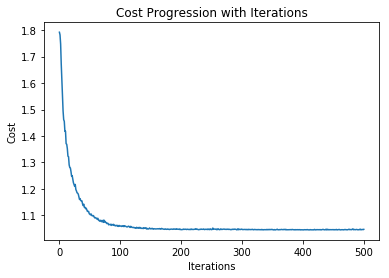

Train Accuracy:  99.90196228027344
Test Accuracy:  93.33333373069763
Max Test Accuracy: 95.55555582046509 on iteration 180
Learning rate:  0.009
Keep probability:  0.8
Time elapsed :  29.903369132677714
**********Learning rate******0.009********Keep prob***********0.8****lamda 10.0
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1666666716337204
Accuracy Test: 0.16666667 on iteration 0
Cost is 1.7923231 for iteration: 0
Max till now is  0.3055555522441864
Accuracy Test: 0.30555555 on iteration 1
Cost is 1.7822574 for iteration: 1
Accuracy Test: 0.30555555 on

Accuracy Test: 0.8888889 on iteration 87
Cost is 1.0639665 for iteration: 87
Accuracy Test: 0.90555555 on iteration 88
Cost is 1.0625286 for iteration: 88
Max till now is  0.949999988079071
Accuracy Test: 0.95 on iteration 89
Cost is 1.0658705 for iteration: 89
Accuracy Test: 0.9166667 on iteration 90
Cost is 1.0616281 for iteration: 90
Accuracy Test: 0.8888889 on iteration 91
Cost is 1.0617777 for iteration: 91
Accuracy Test: 0.9111111 on iteration 92
Cost is 1.0600702 for iteration: 92
Accuracy Test: 0.89444447 on iteration 93
Cost is 1.0618815 for iteration: 93
Accuracy Test: 0.9111111 on iteration 94
Cost is 1.0605515 for iteration: 94
Accuracy Test: 0.90555555 on iteration 95
Cost is 1.0618777 for iteration: 95
Accuracy Test: 0.8833333 on iteration 96
Cost is 1.0583003 for iteration: 96
Accuracy Test: 0.9 on iteration 97
Cost is 1.058114 for iteration: 97
Accuracy Test: 0.9111111 on iteration 98
Cost is 1.0617405 for iteration: 98
Accuracy Test: 0.93333334 on iteration 99
Cost is 

Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0470374 for iteration: 191
Accuracy Test: 0.90555555 on iteration 192
Cost is 1.0489973 for iteration: 192
Accuracy Test: 0.9166667 on iteration 193
Cost is 1.0473503 for iteration: 193
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.0478635 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0470679 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0474231 for iteration: 196
Accuracy Test: 0.9388889 on iteration 197
Cost is 1.0463539 for iteration: 197
Accuracy Test: 0.9388889 on iteration 198
Cost is 1.0482222 for iteration: 198
Accuracy Test: 0.9444444 on iteration 199
Cost is 1.0459404 for iteration: 199
Accuracy Test: 0.9388889 on iteration 200
Cost is 1.0457817 for iteration: 200
Accuracy Test: 0.9222222 on iteration 201
Cost is 1.0456473 for iteration: 201
Accuracy Test: 0.9388889 on iteration 202
Cost is 1.0464277 for iteration: 202
Accuracy Test: 0.93333334 on iteration 203
Cost is

Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0475868 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0461788 for iteration: 296
Accuracy Test: 0.92777777 on iteration 297
Cost is 1.0465399 for iteration: 297
Accuracy Test: 0.93333334 on iteration 298
Cost is 1.046095 for iteration: 298
Accuracy Test: 0.9222222 on iteration 299
Cost is 1.0477382 for iteration: 299
Accuracy Test: 0.93333334 on iteration 300
Cost is 1.0471357 for iteration: 300
Accuracy Test: 0.9388889 on iteration 301
Cost is 1.0458244 for iteration: 301
Accuracy Test: 0.9222222 on iteration 302
Cost is 1.0460773 for iteration: 302
Accuracy Test: 0.9222222 on iteration 303
Cost is 1.0462703 for iteration: 303
Accuracy Test: 0.9388889 on iteration 304
Cost is 1.0464704 for iteration: 304
Accuracy Test: 0.92777777 on iteration 305
Cost is 1.0463896 for iteration: 305
Accuracy Test: 0.9222222 on iteration 306
Cost is 1.0457942 for iteration: 306
Accuracy Test: 0.93333334 on iteration 307
Cost

Accuracy Test: 0.92777777 on iteration 399
Cost is 1.0453516 for iteration: 399
Accuracy Test: 0.93333334 on iteration 400
Cost is 1.0449954 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0447208 for iteration: 401
Accuracy Test: 0.9444444 on iteration 402
Cost is 1.0454938 for iteration: 402
Accuracy Test: 0.95 on iteration 403
Cost is 1.0456241 for iteration: 403
Accuracy Test: 0.93333334 on iteration 404
Cost is 1.0453364 for iteration: 404
Accuracy Test: 0.92777777 on iteration 405
Cost is 1.045168 for iteration: 405
Accuracy Test: 0.95 on iteration 406
Cost is 1.0452572 for iteration: 406
Accuracy Test: 0.93333334 on iteration 407
Cost is 1.0460769 for iteration: 407
Accuracy Test: 0.9388889 on iteration 408
Cost is 1.0452654 for iteration: 408
Accuracy Test: 0.95 on iteration 409
Cost is 1.0449132 for iteration: 409
Accuracy Test: 0.9388889 on iteration 410
Cost is 1.0447431 for iteration: 410
Accuracy Test: 0.95 on iteration 411
Cost is 1.044884 for iter

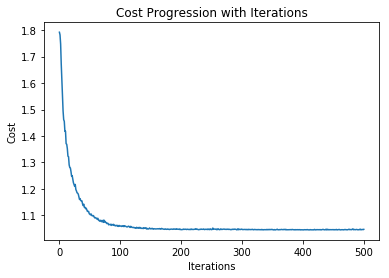

Train Accuracy:  99.90196228027344
Test Accuracy:  93.33333373069763
Max Test Accuracy: 95.55555582046509 on iteration 180
Learning rate:  0.009
Keep probability:  0.8
Time elapsed :  29.971369683742523
**********Learning rate******0.009********Keep prob***********0.8****lamda 0.01
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1666666716337204
Accuracy Test: 0.16666667 on iteration 0
Cost is 1.7923231 for iteration: 0
Max till now is  0.3055555522441864
Accuracy Test: 0.30555555 on iteration 1
Cost is 1.7822574 for iteration: 1
Accuracy Test: 0.30555555 on

Accuracy Test: 0.8888889 on iteration 87
Cost is 1.0639665 for iteration: 87
Accuracy Test: 0.90555555 on iteration 88
Cost is 1.0625286 for iteration: 88
Max till now is  0.949999988079071
Accuracy Test: 0.95 on iteration 89
Cost is 1.0658705 for iteration: 89
Accuracy Test: 0.9166667 on iteration 90
Cost is 1.0616281 for iteration: 90
Accuracy Test: 0.8888889 on iteration 91
Cost is 1.0617777 for iteration: 91
Accuracy Test: 0.9111111 on iteration 92
Cost is 1.0600702 for iteration: 92
Accuracy Test: 0.89444447 on iteration 93
Cost is 1.0618815 for iteration: 93
Accuracy Test: 0.9111111 on iteration 94
Cost is 1.0605515 for iteration: 94
Accuracy Test: 0.90555555 on iteration 95
Cost is 1.0618777 for iteration: 95
Accuracy Test: 0.8833333 on iteration 96
Cost is 1.0583003 for iteration: 96
Accuracy Test: 0.9 on iteration 97
Cost is 1.058114 for iteration: 97
Accuracy Test: 0.9111111 on iteration 98
Cost is 1.0617405 for iteration: 98
Accuracy Test: 0.93333334 on iteration 99
Cost is 

Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0470374 for iteration: 191
Accuracy Test: 0.90555555 on iteration 192
Cost is 1.0489973 for iteration: 192
Accuracy Test: 0.9166667 on iteration 193
Cost is 1.0473503 for iteration: 193
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.0478635 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0470679 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0474231 for iteration: 196
Accuracy Test: 0.9388889 on iteration 197
Cost is 1.0463539 for iteration: 197
Accuracy Test: 0.9388889 on iteration 198
Cost is 1.0482222 for iteration: 198
Accuracy Test: 0.9444444 on iteration 199
Cost is 1.0459404 for iteration: 199
Accuracy Test: 0.9388889 on iteration 200
Cost is 1.0457817 for iteration: 200
Accuracy Test: 0.9222222 on iteration 201
Cost is 1.0456473 for iteration: 201
Accuracy Test: 0.9388889 on iteration 202
Cost is 1.0464277 for iteration: 202
Accuracy Test: 0.93333334 on iteration 203
Cost is

Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0475868 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0461788 for iteration: 296
Accuracy Test: 0.92777777 on iteration 297
Cost is 1.0465399 for iteration: 297
Accuracy Test: 0.93333334 on iteration 298
Cost is 1.046095 for iteration: 298
Accuracy Test: 0.9222222 on iteration 299
Cost is 1.0477382 for iteration: 299
Accuracy Test: 0.93333334 on iteration 300
Cost is 1.0471357 for iteration: 300
Accuracy Test: 0.9388889 on iteration 301
Cost is 1.0458244 for iteration: 301
Accuracy Test: 0.9222222 on iteration 302
Cost is 1.0460773 for iteration: 302
Accuracy Test: 0.9222222 on iteration 303
Cost is 1.0462703 for iteration: 303
Accuracy Test: 0.9388889 on iteration 304
Cost is 1.0464704 for iteration: 304
Accuracy Test: 0.92777777 on iteration 305
Cost is 1.0463896 for iteration: 305
Accuracy Test: 0.9222222 on iteration 306
Cost is 1.0457942 for iteration: 306
Accuracy Test: 0.93333334 on iteration 307
Cost

Accuracy Test: 0.92777777 on iteration 399
Cost is 1.0453516 for iteration: 399
Accuracy Test: 0.93333334 on iteration 400
Cost is 1.0449954 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0447208 for iteration: 401
Accuracy Test: 0.9444444 on iteration 402
Cost is 1.0454938 for iteration: 402
Accuracy Test: 0.95 on iteration 403
Cost is 1.0456241 for iteration: 403
Accuracy Test: 0.93333334 on iteration 404
Cost is 1.0453364 for iteration: 404
Accuracy Test: 0.92777777 on iteration 405
Cost is 1.045168 for iteration: 405
Accuracy Test: 0.95 on iteration 406
Cost is 1.0452572 for iteration: 406
Accuracy Test: 0.93333334 on iteration 407
Cost is 1.0460769 for iteration: 407
Accuracy Test: 0.9388889 on iteration 408
Cost is 1.0452654 for iteration: 408
Accuracy Test: 0.95 on iteration 409
Cost is 1.0449132 for iteration: 409
Accuracy Test: 0.9388889 on iteration 410
Cost is 1.0447431 for iteration: 410
Accuracy Test: 0.95 on iteration 411
Cost is 1.044884 for iter

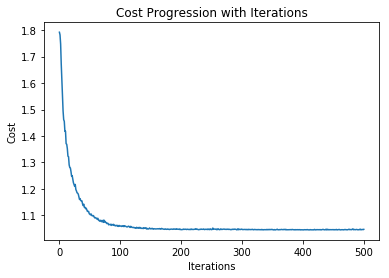

Train Accuracy:  99.90196228027344
Test Accuracy:  93.33333373069763
Max Test Accuracy: 95.55555582046509 on iteration 180
Learning rate:  0.009
Keep probability:  0.8
Time elapsed :  29.687775337696074
**********Learning rate******0.009********Keep prob***********0.8****lamda 0.001
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.1666666716337204
Accuracy Test: 0.16666667 on iteration 0
Cost is 1.7923231 for iteration: 0
Max till now is  0.3055555522441864
Accuracy Test: 0.30555555 on iteration 1
Cost is 1.7822574 for iteration: 1
Accuracy Test: 0.30555555 o

Accuracy Test: 0.8888889 on iteration 87
Cost is 1.0639665 for iteration: 87
Accuracy Test: 0.90555555 on iteration 88
Cost is 1.0625286 for iteration: 88
Max till now is  0.949999988079071
Accuracy Test: 0.95 on iteration 89
Cost is 1.0658705 for iteration: 89
Accuracy Test: 0.9166667 on iteration 90
Cost is 1.0616281 for iteration: 90
Accuracy Test: 0.8888889 on iteration 91
Cost is 1.0617777 for iteration: 91
Accuracy Test: 0.9111111 on iteration 92
Cost is 1.0600702 for iteration: 92
Accuracy Test: 0.89444447 on iteration 93
Cost is 1.0618815 for iteration: 93
Accuracy Test: 0.9111111 on iteration 94
Cost is 1.0605515 for iteration: 94
Accuracy Test: 0.90555555 on iteration 95
Cost is 1.0618777 for iteration: 95
Accuracy Test: 0.8833333 on iteration 96
Cost is 1.0583003 for iteration: 96
Accuracy Test: 0.9 on iteration 97
Cost is 1.058114 for iteration: 97
Accuracy Test: 0.9111111 on iteration 98
Cost is 1.0617405 for iteration: 98
Accuracy Test: 0.93333334 on iteration 99
Cost is 

Accuracy Test: 0.89444447 on iteration 191
Cost is 1.0470374 for iteration: 191
Accuracy Test: 0.90555555 on iteration 192
Cost is 1.0489973 for iteration: 192
Accuracy Test: 0.9166667 on iteration 193
Cost is 1.0473503 for iteration: 193
Accuracy Test: 0.9222222 on iteration 194
Cost is 1.0478635 for iteration: 194
Accuracy Test: 0.9222222 on iteration 195
Cost is 1.0470679 for iteration: 195
Accuracy Test: 0.9111111 on iteration 196
Cost is 1.0474231 for iteration: 196
Accuracy Test: 0.9388889 on iteration 197
Cost is 1.0463539 for iteration: 197
Accuracy Test: 0.9388889 on iteration 198
Cost is 1.0482222 for iteration: 198
Accuracy Test: 0.9444444 on iteration 199
Cost is 1.0459404 for iteration: 199
Accuracy Test: 0.9388889 on iteration 200
Cost is 1.0457817 for iteration: 200
Accuracy Test: 0.9222222 on iteration 201
Cost is 1.0456473 for iteration: 201
Accuracy Test: 0.9388889 on iteration 202
Cost is 1.0464277 for iteration: 202
Accuracy Test: 0.93333334 on iteration 203
Cost is

Accuracy Test: 0.92777777 on iteration 295
Cost is 1.0475868 for iteration: 295
Accuracy Test: 0.90555555 on iteration 296
Cost is 1.0461788 for iteration: 296
Accuracy Test: 0.92777777 on iteration 297
Cost is 1.0465399 for iteration: 297
Accuracy Test: 0.93333334 on iteration 298
Cost is 1.046095 for iteration: 298
Accuracy Test: 0.9222222 on iteration 299
Cost is 1.0477382 for iteration: 299
Accuracy Test: 0.93333334 on iteration 300
Cost is 1.0471357 for iteration: 300
Accuracy Test: 0.9388889 on iteration 301
Cost is 1.0458244 for iteration: 301
Accuracy Test: 0.9222222 on iteration 302
Cost is 1.0460773 for iteration: 302
Accuracy Test: 0.9222222 on iteration 303
Cost is 1.0462703 for iteration: 303
Accuracy Test: 0.9388889 on iteration 304
Cost is 1.0464704 for iteration: 304
Accuracy Test: 0.92777777 on iteration 305
Cost is 1.0463896 for iteration: 305
Accuracy Test: 0.9222222 on iteration 306
Cost is 1.0457942 for iteration: 306
Accuracy Test: 0.93333334 on iteration 307
Cost

Accuracy Test: 0.92777777 on iteration 399
Cost is 1.0453516 for iteration: 399
Accuracy Test: 0.93333334 on iteration 400
Cost is 1.0449954 for iteration: 400
Accuracy Test: 0.92777777 on iteration 401
Cost is 1.0447208 for iteration: 401
Accuracy Test: 0.9444444 on iteration 402
Cost is 1.0454938 for iteration: 402
Accuracy Test: 0.95 on iteration 403
Cost is 1.0456241 for iteration: 403
Accuracy Test: 0.93333334 on iteration 404
Cost is 1.0453364 for iteration: 404
Accuracy Test: 0.92777777 on iteration 405
Cost is 1.045168 for iteration: 405
Accuracy Test: 0.95 on iteration 406
Cost is 1.0452572 for iteration: 406
Accuracy Test: 0.93333334 on iteration 407
Cost is 1.0460769 for iteration: 407
Accuracy Test: 0.9388889 on iteration 408
Cost is 1.0452654 for iteration: 408
Accuracy Test: 0.95 on iteration 409
Cost is 1.0449132 for iteration: 409
Accuracy Test: 0.9388889 on iteration 410
Cost is 1.0447431 for iteration: 410
Accuracy Test: 0.95 on iteration 411
Cost is 1.044884 for iter

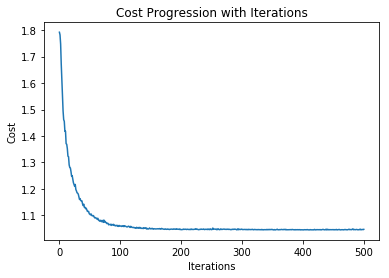

Train Accuracy:  99.90196228027344
Test Accuracy:  93.33333373069763
Max Test Accuracy: 95.55555582046509 on iteration 180
Learning rate:  0.009
Keep probability:  0.8
Time elapsed :  31.838391784826914
**********Learning rate******0.009********Keep prob***********0.9****lamda 0.1
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.17777778208255768
Accuracy Test: 0.17777778 on iteration 0
Cost is 1.7922198 for iteration: 0
Max till now is  0.2666666805744171
Accuracy Test: 0.26666668 on iteration 1
Cost is 1.794524 for iteration: 1
Max till now is  0.3777777850

Accuracy Test: 0.9222222 on iteration 83
Cost is 1.0614269 for iteration: 83
Accuracy Test: 0.9 on iteration 84
Cost is 1.0621381 for iteration: 84
Accuracy Test: 0.89444447 on iteration 85
Cost is 1.0585963 for iteration: 85
Accuracy Test: 0.87222224 on iteration 86
Cost is 1.0593406 for iteration: 86
Accuracy Test: 0.90555555 on iteration 87
Cost is 1.0600691 for iteration: 87
Accuracy Test: 0.8833333 on iteration 88
Cost is 1.057436 for iteration: 88
Accuracy Test: 0.9 on iteration 89
Cost is 1.0584215 for iteration: 89
Accuracy Test: 0.9111111 on iteration 90
Cost is 1.0592997 for iteration: 90
Accuracy Test: 0.87222224 on iteration 91
Cost is 1.0578134 for iteration: 91
Accuracy Test: 0.9166667 on iteration 92
Cost is 1.0569645 for iteration: 92
Accuracy Test: 0.8888889 on iteration 93
Cost is 1.0579914 for iteration: 93
Accuracy Test: 0.9111111 on iteration 94
Cost is 1.0582573 for iteration: 94
Accuracy Test: 0.90555555 on iteration 95
Cost is 1.0575811 for iteration: 95
Accurac

Accuracy Test: 0.9111111 on iteration 188
Cost is 1.0510974 for iteration: 188
Accuracy Test: 0.9166667 on iteration 189
Cost is 1.052245 for iteration: 189
Accuracy Test: 0.89444447 on iteration 190
Cost is 1.0509762 for iteration: 190
Accuracy Test: 0.9 on iteration 191
Cost is 1.0512015 for iteration: 191
Accuracy Test: 0.9111111 on iteration 192
Cost is 1.0511845 for iteration: 192
Accuracy Test: 0.90555555 on iteration 193
Cost is 1.0510236 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.0514328 for iteration: 194
Accuracy Test: 0.90555555 on iteration 195
Cost is 1.0508457 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.0517204 for iteration: 196
Accuracy Test: 0.9222222 on iteration 197
Cost is 1.0510415 for iteration: 197
Accuracy Test: 0.9111111 on iteration 198
Cost is 1.0512598 for iteration: 198
Accuracy Test: 0.9 on iteration 199
Cost is 1.0520827 for iteration: 199
Accuracy Test: 0.9222222 on iteration 200
Cost is 1.0514814 for ite

Accuracy Test: 0.9222222 on iteration 292
Cost is 1.0493544 for iteration: 292
Accuracy Test: 0.9166667 on iteration 293
Cost is 1.0497379 for iteration: 293
Accuracy Test: 0.8888889 on iteration 294
Cost is 1.0491737 for iteration: 294
Accuracy Test: 0.90555555 on iteration 295
Cost is 1.0508397 for iteration: 295
Accuracy Test: 0.89444447 on iteration 296
Cost is 1.0509355 for iteration: 296
Accuracy Test: 0.90555555 on iteration 297
Cost is 1.0495582 for iteration: 297
Accuracy Test: 0.9 on iteration 298
Cost is 1.049636 for iteration: 298
Accuracy Test: 0.9222222 on iteration 299
Cost is 1.0508195 for iteration: 299
Accuracy Test: 0.9111111 on iteration 300
Cost is 1.049557 for iteration: 300
Accuracy Test: 0.9111111 on iteration 301
Cost is 1.0494626 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0494279 for iteration: 302
Accuracy Test: 0.90555555 on iteration 303
Cost is 1.0500787 for iteration: 303
Accuracy Test: 0.92777777 on iteration 304
Cost is 1.049

Accuracy Test: 0.9222222 on iteration 396
Cost is 1.0492584 for iteration: 396
Accuracy Test: 0.9166667 on iteration 397
Cost is 1.0493351 for iteration: 397
Accuracy Test: 0.9111111 on iteration 398
Cost is 1.0496378 for iteration: 398
Accuracy Test: 0.9166667 on iteration 399
Cost is 1.0495931 for iteration: 399
Accuracy Test: 0.93333334 on iteration 400
Cost is 1.0489295 for iteration: 400
Accuracy Test: 0.9222222 on iteration 401
Cost is 1.0492455 for iteration: 401
Accuracy Test: 0.92777777 on iteration 402
Cost is 1.0490488 for iteration: 402
Accuracy Test: 0.9166667 on iteration 403
Cost is 1.049265 for iteration: 403
Accuracy Test: 0.9222222 on iteration 404
Cost is 1.0490956 for iteration: 404
Accuracy Test: 0.92777777 on iteration 405
Cost is 1.0494796 for iteration: 405
Accuracy Test: 0.9111111 on iteration 406
Cost is 1.0489892 for iteration: 406
Accuracy Test: 0.93333334 on iteration 407
Cost is 1.0491513 for iteration: 407
Accuracy Test: 0.9111111 on iteration 408
Cost is

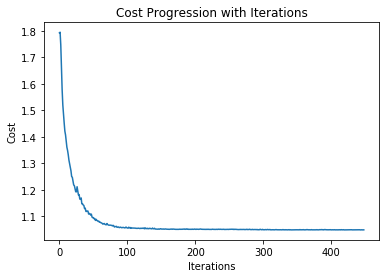

Train Accuracy:  99.41176176071167
Test Accuracy:  91.66666865348816
Max Test Accuracy: 94.44444179534912 on iteration 323
Learning rate:  0.009
Keep probability:  0.9
Time elapsed :  25.809188016255696
**********Learning rate******0.009********Keep prob***********0.9****lamda 10.0
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.17777778208255768
Accuracy Test: 0.17777778 on iteration 0
Cost is 1.7922198 for iteration: 0
Max till now is  0.2666666805744171
Accuracy Test: 0.26666668 on iteration 1
Cost is 1.794524 for iteration: 1
Max till now is  0.377777785

Accuracy Test: 0.9222222 on iteration 83
Cost is 1.0614269 for iteration: 83
Accuracy Test: 0.9 on iteration 84
Cost is 1.0621381 for iteration: 84
Accuracy Test: 0.89444447 on iteration 85
Cost is 1.0585963 for iteration: 85
Accuracy Test: 0.87222224 on iteration 86
Cost is 1.0593406 for iteration: 86
Accuracy Test: 0.90555555 on iteration 87
Cost is 1.0600691 for iteration: 87
Accuracy Test: 0.8833333 on iteration 88
Cost is 1.057436 for iteration: 88
Accuracy Test: 0.9 on iteration 89
Cost is 1.0584215 for iteration: 89
Accuracy Test: 0.9111111 on iteration 90
Cost is 1.0592997 for iteration: 90
Accuracy Test: 0.87222224 on iteration 91
Cost is 1.0578134 for iteration: 91
Accuracy Test: 0.9166667 on iteration 92
Cost is 1.0569645 for iteration: 92
Accuracy Test: 0.8888889 on iteration 93
Cost is 1.0579914 for iteration: 93
Accuracy Test: 0.9111111 on iteration 94
Cost is 1.0582573 for iteration: 94
Accuracy Test: 0.90555555 on iteration 95
Cost is 1.0575811 for iteration: 95
Accurac

Accuracy Test: 0.9111111 on iteration 188
Cost is 1.0510974 for iteration: 188
Accuracy Test: 0.9166667 on iteration 189
Cost is 1.052245 for iteration: 189
Accuracy Test: 0.89444447 on iteration 190
Cost is 1.0509762 for iteration: 190
Accuracy Test: 0.9 on iteration 191
Cost is 1.0512015 for iteration: 191
Accuracy Test: 0.9111111 on iteration 192
Cost is 1.0511845 for iteration: 192
Accuracy Test: 0.90555555 on iteration 193
Cost is 1.0510236 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.0514328 for iteration: 194
Accuracy Test: 0.90555555 on iteration 195
Cost is 1.0508457 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.0517204 for iteration: 196
Accuracy Test: 0.9222222 on iteration 197
Cost is 1.0510415 for iteration: 197
Accuracy Test: 0.9111111 on iteration 198
Cost is 1.0512598 for iteration: 198
Accuracy Test: 0.9 on iteration 199
Cost is 1.0520827 for iteration: 199
Accuracy Test: 0.9222222 on iteration 200
Cost is 1.0514814 for ite

Accuracy Test: 0.9222222 on iteration 292
Cost is 1.0493544 for iteration: 292
Accuracy Test: 0.9166667 on iteration 293
Cost is 1.0497379 for iteration: 293
Accuracy Test: 0.8888889 on iteration 294
Cost is 1.0491737 for iteration: 294
Accuracy Test: 0.90555555 on iteration 295
Cost is 1.0508397 for iteration: 295
Accuracy Test: 0.89444447 on iteration 296
Cost is 1.0509355 for iteration: 296
Accuracy Test: 0.90555555 on iteration 297
Cost is 1.0495582 for iteration: 297
Accuracy Test: 0.9 on iteration 298
Cost is 1.049636 for iteration: 298
Accuracy Test: 0.9222222 on iteration 299
Cost is 1.0508195 for iteration: 299
Accuracy Test: 0.9111111 on iteration 300
Cost is 1.049557 for iteration: 300
Accuracy Test: 0.9111111 on iteration 301
Cost is 1.0494626 for iteration: 301
Accuracy Test: 0.9166667 on iteration 302
Cost is 1.0494279 for iteration: 302
Accuracy Test: 0.90555555 on iteration 303
Cost is 1.0500787 for iteration: 303
Accuracy Test: 0.92777777 on iteration 304
Cost is 1.049

Accuracy Test: 0.9222222 on iteration 396
Cost is 1.0492584 for iteration: 396
Accuracy Test: 0.9166667 on iteration 397
Cost is 1.0493351 for iteration: 397
Accuracy Test: 0.9111111 on iteration 398
Cost is 1.0496378 for iteration: 398
Accuracy Test: 0.9166667 on iteration 399
Cost is 1.0495931 for iteration: 399
Accuracy Test: 0.93333334 on iteration 400
Cost is 1.0489295 for iteration: 400
Accuracy Test: 0.9222222 on iteration 401
Cost is 1.0492455 for iteration: 401
Accuracy Test: 0.92777777 on iteration 402
Cost is 1.0490488 for iteration: 402
Accuracy Test: 0.9166667 on iteration 403
Cost is 1.049265 for iteration: 403
Accuracy Test: 0.9222222 on iteration 404
Cost is 1.0490956 for iteration: 404
Accuracy Test: 0.92777777 on iteration 405
Cost is 1.0494796 for iteration: 405
Accuracy Test: 0.9111111 on iteration 406
Cost is 1.0489892 for iteration: 406
Accuracy Test: 0.93333334 on iteration 407
Cost is 1.0491513 for iteration: 407
Accuracy Test: 0.9111111 on iteration 408
Cost is

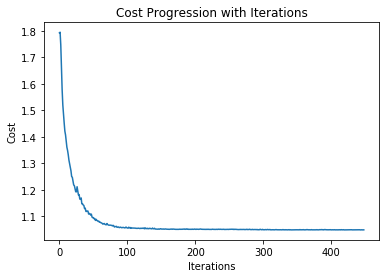

Train Accuracy:  99.41176176071167
Test Accuracy:  91.66666865348816
Max Test Accuracy: 94.44444179534912 on iteration 323
Learning rate:  0.009
Keep probability:  0.9
Time elapsed :  22.118805714448293
**********Learning rate******0.009********Keep prob***********0.9****lamda 0.01
Tensor("dropout/mul:0", shape=(?, 64, 64, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 32, 32, 8), dtype=float32)
 pad 0 f 3 stid 1 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 30, 30, 16), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3600), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.17777778208255768
Accuracy Test: 0.17777778 on iteration 0
Cost is 1.7922198 for iteration: 0
Max till now is  0.2666666805744171
Accuracy Test: 0.26666668 on iteration 1
Cost is 1.794524 for iteration: 1
Max till now is  0.377777785

Accuracy Test: 0.9222222 on iteration 83
Cost is 1.0614269 for iteration: 83
Accuracy Test: 0.9 on iteration 84
Cost is 1.0621381 for iteration: 84
Accuracy Test: 0.89444447 on iteration 85
Cost is 1.0585963 for iteration: 85
Accuracy Test: 0.87222224 on iteration 86
Cost is 1.0593406 for iteration: 86
Accuracy Test: 0.90555555 on iteration 87
Cost is 1.0600691 for iteration: 87
Accuracy Test: 0.8833333 on iteration 88
Cost is 1.057436 for iteration: 88
Accuracy Test: 0.9 on iteration 89
Cost is 1.0584215 for iteration: 89
Accuracy Test: 0.9111111 on iteration 90
Cost is 1.0592997 for iteration: 90
Accuracy Test: 0.87222224 on iteration 91
Cost is 1.0578134 for iteration: 91
Accuracy Test: 0.9166667 on iteration 92
Cost is 1.0569645 for iteration: 92
Accuracy Test: 0.8888889 on iteration 93
Cost is 1.0579914 for iteration: 93
Accuracy Test: 0.9111111 on iteration 94
Cost is 1.0582573 for iteration: 94
Accuracy Test: 0.90555555 on iteration 95
Cost is 1.0575811 for iteration: 95
Accurac

Accuracy Test: 0.9111111 on iteration 188
Cost is 1.0510974 for iteration: 188
Accuracy Test: 0.9166667 on iteration 189
Cost is 1.052245 for iteration: 189
Accuracy Test: 0.89444447 on iteration 190
Cost is 1.0509762 for iteration: 190
Accuracy Test: 0.9 on iteration 191
Cost is 1.0512015 for iteration: 191
Accuracy Test: 0.9111111 on iteration 192
Cost is 1.0511845 for iteration: 192
Accuracy Test: 0.90555555 on iteration 193
Cost is 1.0510236 for iteration: 193
Accuracy Test: 0.9 on iteration 194
Cost is 1.0514328 for iteration: 194
Accuracy Test: 0.90555555 on iteration 195
Cost is 1.0508457 for iteration: 195
Accuracy Test: 0.89444447 on iteration 196
Cost is 1.0517204 for iteration: 196
Accuracy Test: 0.9222222 on iteration 197
Cost is 1.0510415 for iteration: 197
Accuracy Test: 0.9111111 on iteration 198
Cost is 1.0512598 for iteration: 198
Accuracy Test: 0.9 on iteration 199
Cost is 1.0520827 for iteration: 199
Accuracy Test: 0.9222222 on iteration 200
Cost is 1.0514814 for ite

KeyboardInterrupt: 

In [8]:
for learning_rate in [0.011, 0.009,0.012]:
    for keep_prob in [0.7,0.8, 0.9]:
        for lam in [0.1, 10.0, 0.01, 0.001]:
            print("**********Learning rate******{}********Keep prob***********{}****lamda {}".format(learning_rate, keep_prob, lam))
            train_cnn_lenet5(500, X_train_norm, y_train_encoded, X_test_norm, y_test_encoded, learning_rate, keep_prob, lam)

### 5. (20pts) Predictions